# Mobile VE As Default AB Test

**Megan Neisler, Senior Data Scientist, Wikimedia Foundation**

**18 January 2022**

[Task](https://phabricator.wikimedia.org/T221198)| [Codebase](https://gitlab.wikimedia.org/mneisler/mobile-ve-as-default-ab-analysis-2023)


# Contents

1. [Introduction](#Introduction)
2. [Methodology](#Methodology)
3. [Editor retention](#Editor-retention)
4. [Edit completion rate](#Edit-completion-rate)
5. [Proportion of editors who make at least 1 successful edit](#Proportion-of-editors-who-make-at-least-1-successful-edit)
6. [Edit quality](#Edit-quality)
7. [Disruption](#Disruption)
8. [Total number of completed edits](#Total-number-of-completed-edits)
9. [Load time](#Load-time)


# Introduction

The Wikimedia Foundation's [Editing team](https://www.mediawiki.org/wiki/Editing_team#:~:text=The%20Editing%20team%20is%20the,tools%20like%20TemplateData%20and%20Citoid.) is working to simplify contributing on mobile.

As part of this effort, the Editing team experimented with VisualEditor being the default mobile editor on a select number of partner wikis.  Currently, all contributors are presented with the wikitext editor when they first tap "edit" on the mobile website. 

The team ran an AB test from 1 November 2019 through 26 September 2022 to determine what editing interface when presented as default is more likely to cause new contributors to continue editing Wikipedia. During this test, 50% of users included in the test were shown VisualEditor as the default editor on mobile, and 50% still were shown wikitext as the default editor. 

The test included all mobile contributors to the 20 participating wikis, registered and unregistered, who have not edited on any platform before at once of the participating Wikipedias during the duration of the AB Test (see full list of participating Wikipedias on the [this task description](https://phabricator.wikimedia.org/T221196).  The AB Test was also limited to to people who have not edited on any platform.  

You can find more information about features of this tool and project updates on the [project page](https://www.mediawiki.org/wiki/VisualEditor_on_mobile/VE_mobile_default).

Note: An initial AB test was run from 9 July 2019 through 31 October 2019 on the participating Wikipedias; however, this data was discarded, due to an issue in bucketing implementation that caused some users in the test to not be assigned a bucket. 


# Methodology


The AB test was run on a per Wikipedia basis and mobile contributors included in the test were randomly assigned to either the control (wikitext shown as the default editor) or treatment (VisualEditor was shown as the default editor). Users at these Wikipedias were still able to switch their editor using the drop-down in the editing toolbar; however, they remained in the same group they were bucketed in for the duration of the test. 

While the AB test was run from 01 November 2019 through 26 September 2022, we only retained data on unique anonymous users for the last 90 days (July 2022 - September 2022)  in accordance with data retention policies.

Data on the each user's editing workflow was collected in [EditAttemptStep](https://gerrit.wikimedia.org/r/plugins/gitiles/schemas/event/secondary/+/refs/heads/master/jsonschema/analytics/legacy/editattemptstep/). This data was also supplemented with edit revert data contined in [mediawiki_history](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Edits/MediaWiki_history).  

Reviewed data was limited to edits on mobile web on Wikipedia projects on a main namespace.

See the following Phabricator tickets and patches for further details regarding instrumentation and implementation of the AB test:

* List of Participating Wikipedias [T221196](https://phabricator.wikimedia.org/T221196)
* Test Sampling [T227317](https://phabricator.wikimedia.org/T227317)
* Measurement Plan [T221187](https://phabricator.wikimedia.org/T221187)
* AB Test Design [T221195](https://phabricator.wikimedia.org/T221195)
* Bucketing Patch [T236337](https://phabricator.wikimedia.org/T236337)
* Rerun AB Test [Patch 546724](https://gerrit.wikimedia.org/r/c/operations/mediawiki-config/+/546724/)



In [20]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse)
    library(lubridate)
    # Tables:
    library(gt)
    library(gtsummary)
    # Misc
    library(dplyr, warn.conflicts = FALSE)
})

In [21]:
options(dplyr.summarise.inform = FALSE)
options(repr.plot.width = 15, repr.plot.height = 10)

# Editor retention 

Editor retention was selected as the key performance metric for this AB test. Our priority is the long-term health of Wikimedia projects. This "health" depends on people continuing to edit and retention is the best metric we have to measure how likely it is that people who start editing will come back to do it again. 

We were interested in understanding if people who are shown the visual editor by default are more likely to continue editing. To measure this, we looked at the retention rate of users in the test. 

For this analysis, we reviewed the percent of new editors that published their first mobile edit to a page in the main namespace on a Wikipedia project during the AB test and returned to publish at least 1 mobile edit on Wikipedia project on any page namespace during the identified retention time periods (2 weeks, 2 months, and 6 months). This was identified as the key performance metric for this analysis.

Reviewed time frame:
Depending on the status of the user (registered or unregistered), we reviewed events logged in different time periods. 
For registered users, we retained data from the full duration of the AB test and, as a result, are able to measure long-term retention of these users (November 2019 - September 2022) 
For unregistered users, we only retain data for the last 90 days of the AB test (July 2022 - September 2022) so we are only able to review retention of editors during that time period. As a result, we were not able to review the long-term retention of these editors. We are also not able to confirm if the logged out user was a newcomer. 
 


## Second Week Retention Rate

Defined as a user in the test making an edit to an main namespace and returning to make an edit to any main namespace between days 8 to 14. 


In [4]:
# load in retention for logged-in users
second_week_retention_loggedin <-
  read.csv(
    file = 'Data/second_week_retention_loggedin.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) 


In [5]:
# load in retention for logged_out users
second_week_retention_loggedout <-
  read.csv(
    file = 'Data/second_week_retention_logged_out.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) 


In [6]:
#reformat and clean data
# add columns to specifiy logged in status so results can be combined
second_week_retention_loggedin <- second_week_retention_loggedin %>%
    mutate(user_is_anon = 'registered')

second_week_retention_loggedout <- second_week_retention_loggedout %>%
    mutate(user_is_anon = 'unregistered')

#join datasets
second_week_retention_all <- rbind(second_week_retention_loggedin, second_week_retention_loggedout)


# set correct factor levels

second_week_retention_all$bucket <-
  factor(
    second_week_retention_all$bucket,
    levels = c('default-source', 'default-visual'),
    labels = c("Wikitext as default", "VisualEditor as default")
  )
#clarfiy wiki names
second_week_retention_all <- second_week_retention_all %>%
  mutate(
    wiki = case_when(
      #clarfiy participating project names
      wiki == 'azwiki' ~ 'Azerbaijani Wikipedia', 
      wiki == 'bgwiki' ~ 'Bulgarian Wikipedia', 
      wiki == 'cawiki' ~ 'Catalan Wikipedia',  
      wiki == 'zh_yuewiki' ~ 'Cantonese Wikipedia', 
      wiki == 'hrwiki' ~ 'Croatian Wikipedia', 
      wiki == 'dawiki' ~ 'Danish Wikipedia', 
      wiki == 'etwiki' ~ 'Estonian Wikipedia', 
      wiki == 'fiwiki' ~ 'Finnish Wikipedia',    
      wiki == 'elwiki' ~ 'Greek Wikipedia', 
      wiki == 'huwiki' ~ 'Hungarian Wikipedia',
      wiki == 'mswiki' ~ 'Malay Wikipedia',
        wiki == 'mlwiki' ~ 'Malayalam Wikipedia',
        wiki == 'nowiki' ~ 'Norwegian Wikipedia',
        wiki == 'ptwiki' ~ 'Portuguese Wikipedia',
        wiki == 'rowiki' ~ 'Romanian Wikipedia',
        wiki == 'satwiki' ~ 'Santali Wikipedia',
        wiki == 'srwiki' ~ 'Serbian Wikipedia',
        wiki == 'svwiki' ~ 'Swedish Wikipedia',
        wiki == 'tawiki' ~ 'Tamil Wikipedia',
        wiki == 'thwiki' ~ 'Thai Wikipedia',
        wiki == 'urwiki' ~ 'Urdu Wikipedia'
))


### Overall Second Week Retention Rate 

Includes both registered and unregistered contributors.

In [7]:
second_week_retention_overall <- second_week_retention_all %>%
    group_by(bucket)  %>%
    summarise(return_editors = sum(return_editors),
              editors = sum(editors),
        retention_rate = paste0(round(return_editors/editors * 100, 1), "%"))
              

In [8]:
# Create table of completion rate
second_week_retention_overall_table <- second_week_retention_overall %>%
  gt() %>%
  tab_header(
    title = "Overall Second Week Retention Rate",
    subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    bucket = "Test Group",
    return_editors = "Number of returning editors",
    editors = "Number of editors",
    retention_rate = "Retention rate"
  ) %>%
  tab_footnote(
    footnote = "Defined as percent of contributors that made their first edit during the AB test and made another edit within 8 to 14 days",
    locations = cells_column_labels(
      columns = 'retention_rate'
    )
  ) %>%
  tab_footnote(
    footnote = "Includes both registered and unregistered editors",
    locations = cells_column_labels(
      columns = c('editors', 'return_editors')
    )
  )%>%
    gtsave(
    "second_week_retention_overall_table.html", inline_css = TRUE)

IRdisplay::display_html(data = second_week_retention_overall_table, file = "second_week_retention_overall_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 Overall Second Week Retention Rate 
 
 
 across all participating Wikipedias 
 
 
 
 
 Test Group 
 Number of returning editors 1 
 Number of editors 1 
 Retention rate 2 
 
 
 
 
 Wikitext as default 
 752 
 37014 
 2% 
 
 
 VisualEditor as default 
 640 
 37273 
 1.7% 
 
 
 
 
 
 
 
 
 1 
 
 
 Includes both registered and unregistered editors
 
 
 
 
 2 
 
 
 Defined as percent of contributors that made their first edit during the AB test and made another edit within 8 to 14 days

### By Logged-In and Logged-Out

In [9]:
second_week_retention_byanon <- second_week_retention_all %>%
    group_by(bucket, user_is_anon)  %>%
    summarise(return_editors = sum(return_editors),
              editors = sum(editors),
        retention_rate = paste0(round(return_editors/editors * 100, 1), "%"))
              

In [10]:
# Create table of completion rate
second_week_retention_byanon_table <- second_week_retention_byanon %>%
  gt(groupname_col = "user_is_anon") %>%
  tab_header(
    title = "Overall Second Week Retention Rate by Logged-In Status",
    subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    bucket = "Test Group",
    user_is_anon = "Registered Status",
    return_editors = "Number of returning editors",
    editors = "Number of editors",
    retention_rate = "Retention rate"
  ) %>%
  tab_footnote(
    footnote = "Defined as percent of contributors that made their first edit during the AB test and made another edit within 8 to 14 days",
    locations = cells_column_labels(
      columns = 'retention_rate'
    )
  ) %>%
    gtsave(
    "second_week_retention_byanon_table.html", inline_css = TRUE)

IRdisplay::display_html(data = second_week_retention_byanon_table, file = "second_week_retention_byanon_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 Overall Second Week Retention Rate by Logged-In Status 
 
 
 across all participating Wikipedias 
 
 
 
 
 Test Group 
 Number of returning editors 
 Number of editors 
 Retention rate 1 
 
 
 
 
 registered 
 
 
 Wikitext as default 
 718 
 36042 
 2% 
 
 
 VisualEditor as default 
 618 
 36343 
 1.7% 
 
 
 unregistered 
 
 
 Wikitext as default 
 34 
 972 
 3.5% 
 
 
 VisualEditor as default 
 22 
 930 
 2.4% 
 
 
 
 
 
 
 
 
 1 
 
 
 Defined as percent of contributors that made their first edit during the AB test and made another edit within 8 to 14 days

### By Participating Wikipedia

In [395]:
second_week_retention_bywiki <- second_week_retention_all %>%
    group_by (wiki, bucket)  %>%
    summarise(return_editors = sum(return_editors),
              editors = sum(editors),
        retention_rate = paste0(round(return_editors/editors * 100, 1), "%"), .groups = 'drop') 
              

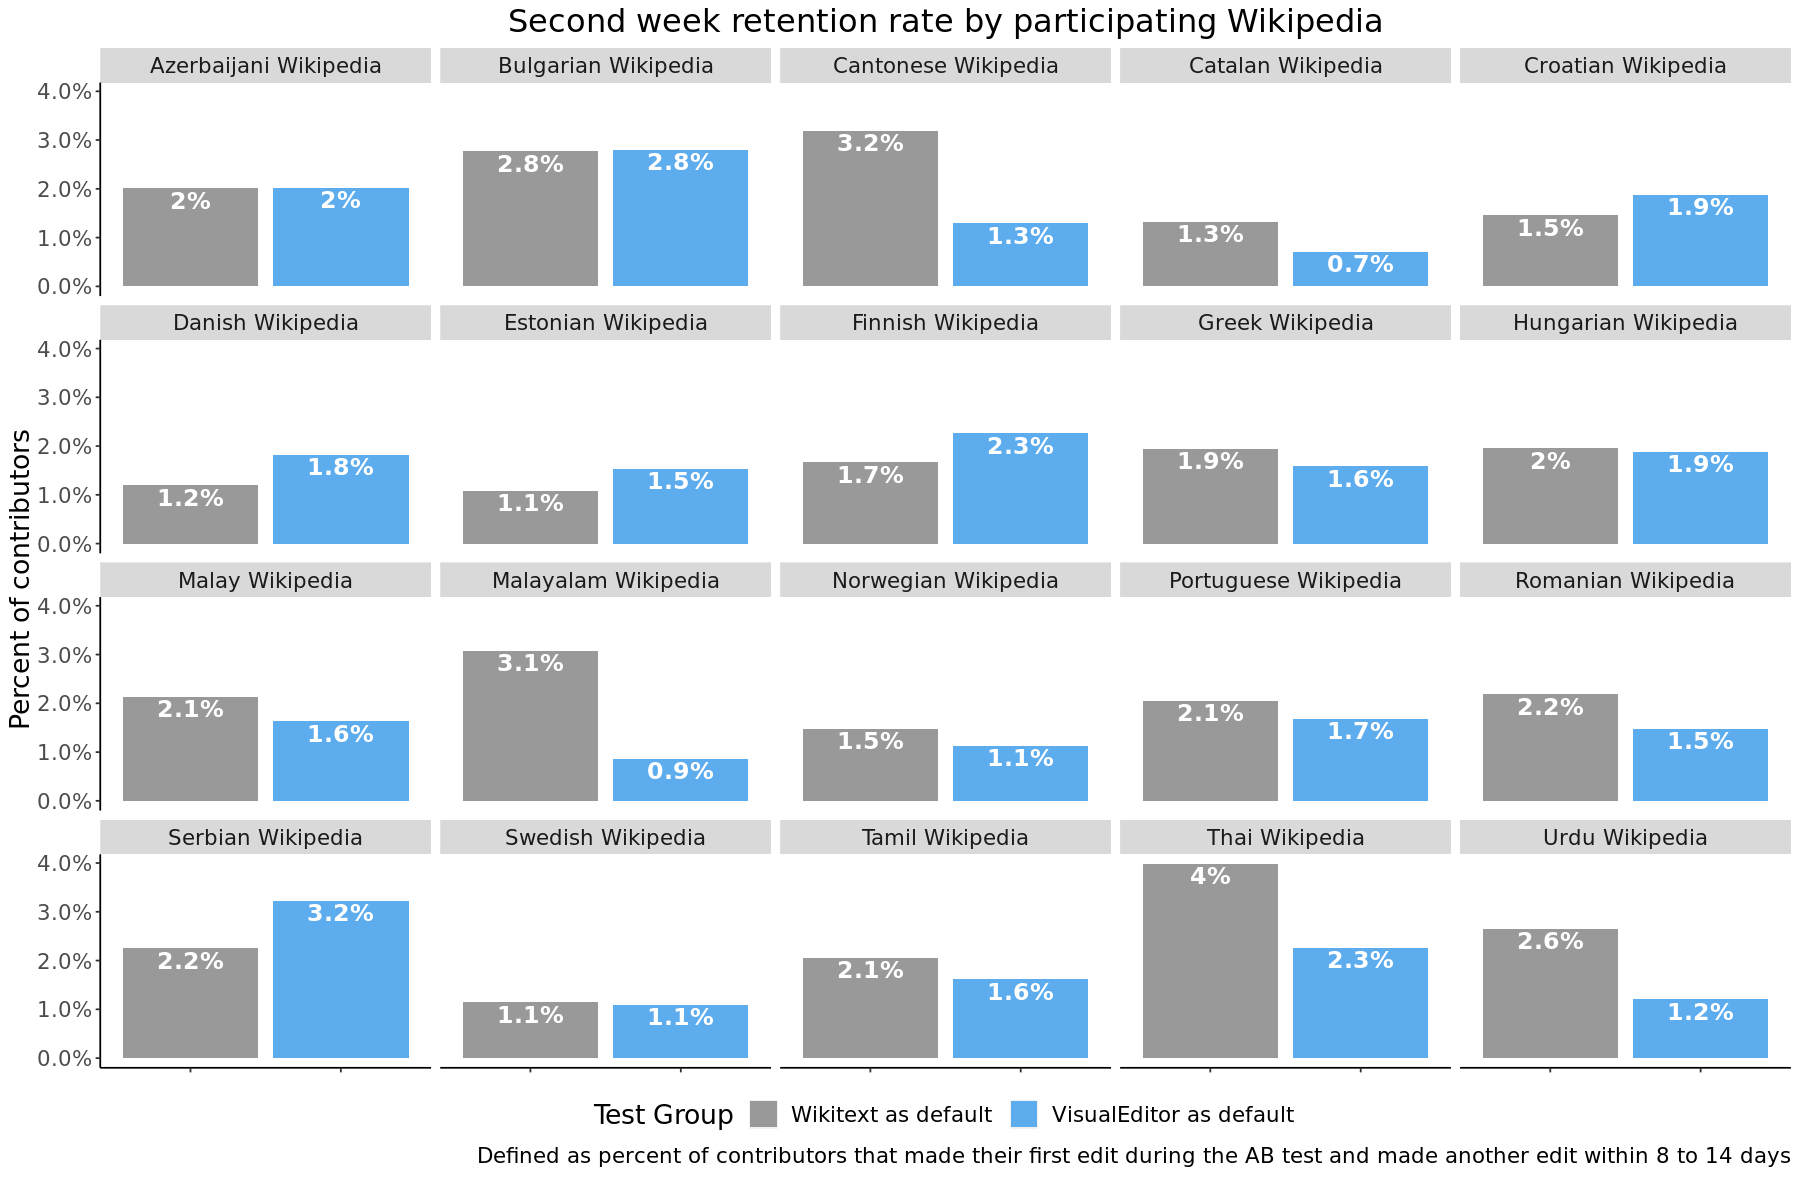

In [396]:
# Plot edit completion rates for each wiki  

dodge <- position_dodge(width=0.9)

p <- second_week_retention_bywiki  %>%
    ggplot(aes(x= bucket, y = return_editors / editors, fill = bucket)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(retention_rate), fontface=2), vjust=1.2, size = 5, color = "white") +
    facet_wrap(~ wiki) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of contributors ",
          title = "Second week retention rate by participating Wikipedia",
         caption = "Defined as percent of contributors that made their first edit during the AB test and made another edit within 8 to 14 days
")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Test Group")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/second_week_retention_bywiki_plot.png", p, width = 16, height = 8, units = "in", dpi = 300)

## Second Month Retention Rate

Defined as a user in the test making an edit to an main namespace and returning to make an edit to any main namespace between days 31 to 60. 

Note: Data for logged out users was limited to just data logged in August 2022 because unique logged out user data is removed after 90 days and could not include any users in September as these users would have returned following the end of the AB test in their second month.

In [11]:
# load in retention
# Dataset limited to time period that included available anon data
second_month_retention_loggedin <-
  read.csv(
    file = 'Data/second_month_retention_loggedin.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) 


In [12]:
# load in retention
# Dataset limited to time period that included available anon data
second_month_retention_loggedout <-
  read.csv(
    file = 'Data/second_month_retention_logged_out.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) 


In [13]:
#reformat and clean data
# add columns to specifiy logged in status so results can be combined
second_month_retention_loggedin <- second_month_retention_loggedin %>%
    mutate(user_is_anon = 'registered')

second_month_retention_loggedout <- second_month_retention_loggedout %>%
    mutate(user_is_anon = 'unregistered')

#join datasets
second_month_retention_all <- rbind(second_month_retention_loggedin, second_month_retention_loggedout)


# set correct factor levels

second_month_retention_all$bucket <-
  factor(
    second_month_retention_all$bucket,
    levels = c('default-source', 'default-visual'),
    labels = c("Wikitext as default", "VisualEditor as default")
  )
#clarfiy wiki names
second_month_retention_all <- second_month_retention_all %>%
  mutate(
    wiki = case_when(
      #clarfiy participating project names
      wiki == 'azwiki' ~ 'Azerbaijani Wikipedia', 
      wiki == 'bgwiki' ~ 'Bulgarian Wikipedia', 
      wiki == 'cawiki' ~ 'Catalan Wikipedia',  
      wiki == 'zh_yuewiki' ~ 'Cantonese Wikipedia', 
      wiki == 'hrwiki' ~ 'Croatian Wikipedia', 
      wiki == 'dawiki' ~ 'Danish Wikipedia', 
      wiki == 'etwiki' ~ 'Estonian Wikipedia', 
      wiki == 'fiwiki' ~ 'Finnish Wikipedia',    
      wiki == 'elwiki' ~ 'Greek Wikipedia', 
      wiki == 'huwiki' ~ 'Hungarian Wikipedia',
      wiki == 'mswiki' ~ 'Malay Wikipedia',
        wiki == 'mlwiki' ~ 'Malayalam Wikipedia',
        wiki == 'nowiki' ~ 'Norwegian Wikipedia',
        wiki == 'ptwiki' ~ 'Portuguese Wikipedia',
        wiki == 'rowiki' ~ 'Romanian Wikipedia',
        wiki == 'satwiki' ~ 'Santali Wikipedia',
        wiki == 'srwiki' ~ 'Serbian Wikipedia',
        wiki == 'svwiki' ~ 'Swedish Wikipedia',
        wiki == 'tawiki' ~ 'Tamil Wikipedia',
        wiki == 'thwiki' ~ 'Thai Wikipedia',
        wiki == 'urwiki' ~ 'Urdu Wikipedia'
))



### Overall

In [14]:
second_month_retention_overall <- second_month_retention_all %>%
    group_by(bucket)  %>%
    summarise(return_editors = sum(return_editors),
              editors = sum(editors),
        retention_rate = paste0(round(return_editors/editors * 100, 1), "%"))
              

In [15]:
# Create table of retention rate
second_month_retention_overall_table <- second_month_retention_overall %>%
  gt() %>%
  tab_header(
    title = "Overall Second Month Retention Rate",
    subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    bucket = "Test Group",
    return_editors = "Number of returning editors",
    editors = "Number of editors",
    retention_rate = "Retention rate"
  ) %>%
  tab_footnote(
    footnote = "Defined as percent of contributors that made their first edit during the AB test and made another edit within 31 to 60 days",
    locations = cells_column_labels(
      columns = 'retention_rate'
    )
  ) %>%
  tab_footnote(
    footnote = "Includes both registered and unregistered editors",
    locations = cells_column_labels(
      columns = c('editors', 'return_editors')
    )
  )%>%
    gtsave(
    "second_month_retention_overall_table.html", inline_css = TRUE)

IRdisplay::display_html(data = second_month_retention_overall_table, file = "second_month_retention_overall_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 Overall Second Month Retention Rate 
 
 
 across all participating Wikipedias 
 
 
 
 
 Test Group 
 Number of returning editors 1 
 Number of editors 1 
 Retention rate 2 
 
 
 
 
 Wikitext as default 
 903 
 36381 
 2.5% 
 
 
 VisualEditor as default 
 840 
 36678 
 2.3% 
 
 
 
 
 
 
 
 
 1 
 
 
 Includes both registered and unregistered editors
 
 
 
 
 2 
 
 
 Defined as percent of contributors that made their first edit during the AB test and made another edit within 31 to 60 days

### By Logged In and Logged Out

In [16]:
second_month_retention_byanon <- second_month_retention_all %>%
    group_by(bucket, user_is_anon)  %>%
    summarise(return_editors = sum(return_editors),
              editors = sum(editors),
        retention_rate = paste0(round(return_editors/editors * 100, 1), "%"))
              

In [19]:
# Create table of completion rate
second_month_retention_byanon_table <- second_month_retention_byanon%>%
  gt(groupname_col = "user_is_anon") %>%
  tab_header(
    title = "Overall Second Month Retention Rate by Registered Status",
    subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    bucket = "Test Group",
    user_is_anon = "Registered Status",
    return_editors = "Number of returning editors",
    editors = "Number of editors",
    retention_rate = "Retention rate"
  ) %>%
  tab_footnote(
    footnote = "Defined as percent of contributors that made their first edit during the AB test and made another edit within 8 to 14 days",
    locations = cells_column_labels(
      columns = 'retention_rate'
    )
  ) %>%
    gtsave(
    "second_month_retention_byanon_table.html", inline_css = TRUE)

IRdisplay::display_html(data = second_month_retention_byanon_table, file = "second_month_retention_byanon_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 Overall Second Month Retention Rate by Registered Status 
 
 
 across all participating Wikipedias 
 
 
 
 
 Test Group 
 Number of returning editors 
 Number of editors 
 Retention rate 1 
 
 
 
 
 registered 
 
 
 Wikitext as default 
 899 
 35940 
 2.5% 
 
 
 VisualEditor as default 
 840 
 36245 
 2.3% 
 
 
 unregistered 
 
 
 Wikitext as default 
 4 
 441 
 0.9% 
 
 
 VisualEditor as default 
 0 
 433 
 0% 
 
 
 
 
 
 
 
 
 1 
 
 
 Defined as percent of contributors that made their first edit during the AB test and made another edit within 8 to 14 days

### By Participating Wikipedia

In [404]:
second_month_retention_bywiki <- second_month_retention_all %>%
    group_by(bucket, wiki)  %>%
    summarise(return_editors = sum(return_editors),
              editors = sum(editors),
        retention_rate = paste0(round(return_editors/editors * 100, 1), "%"))
              

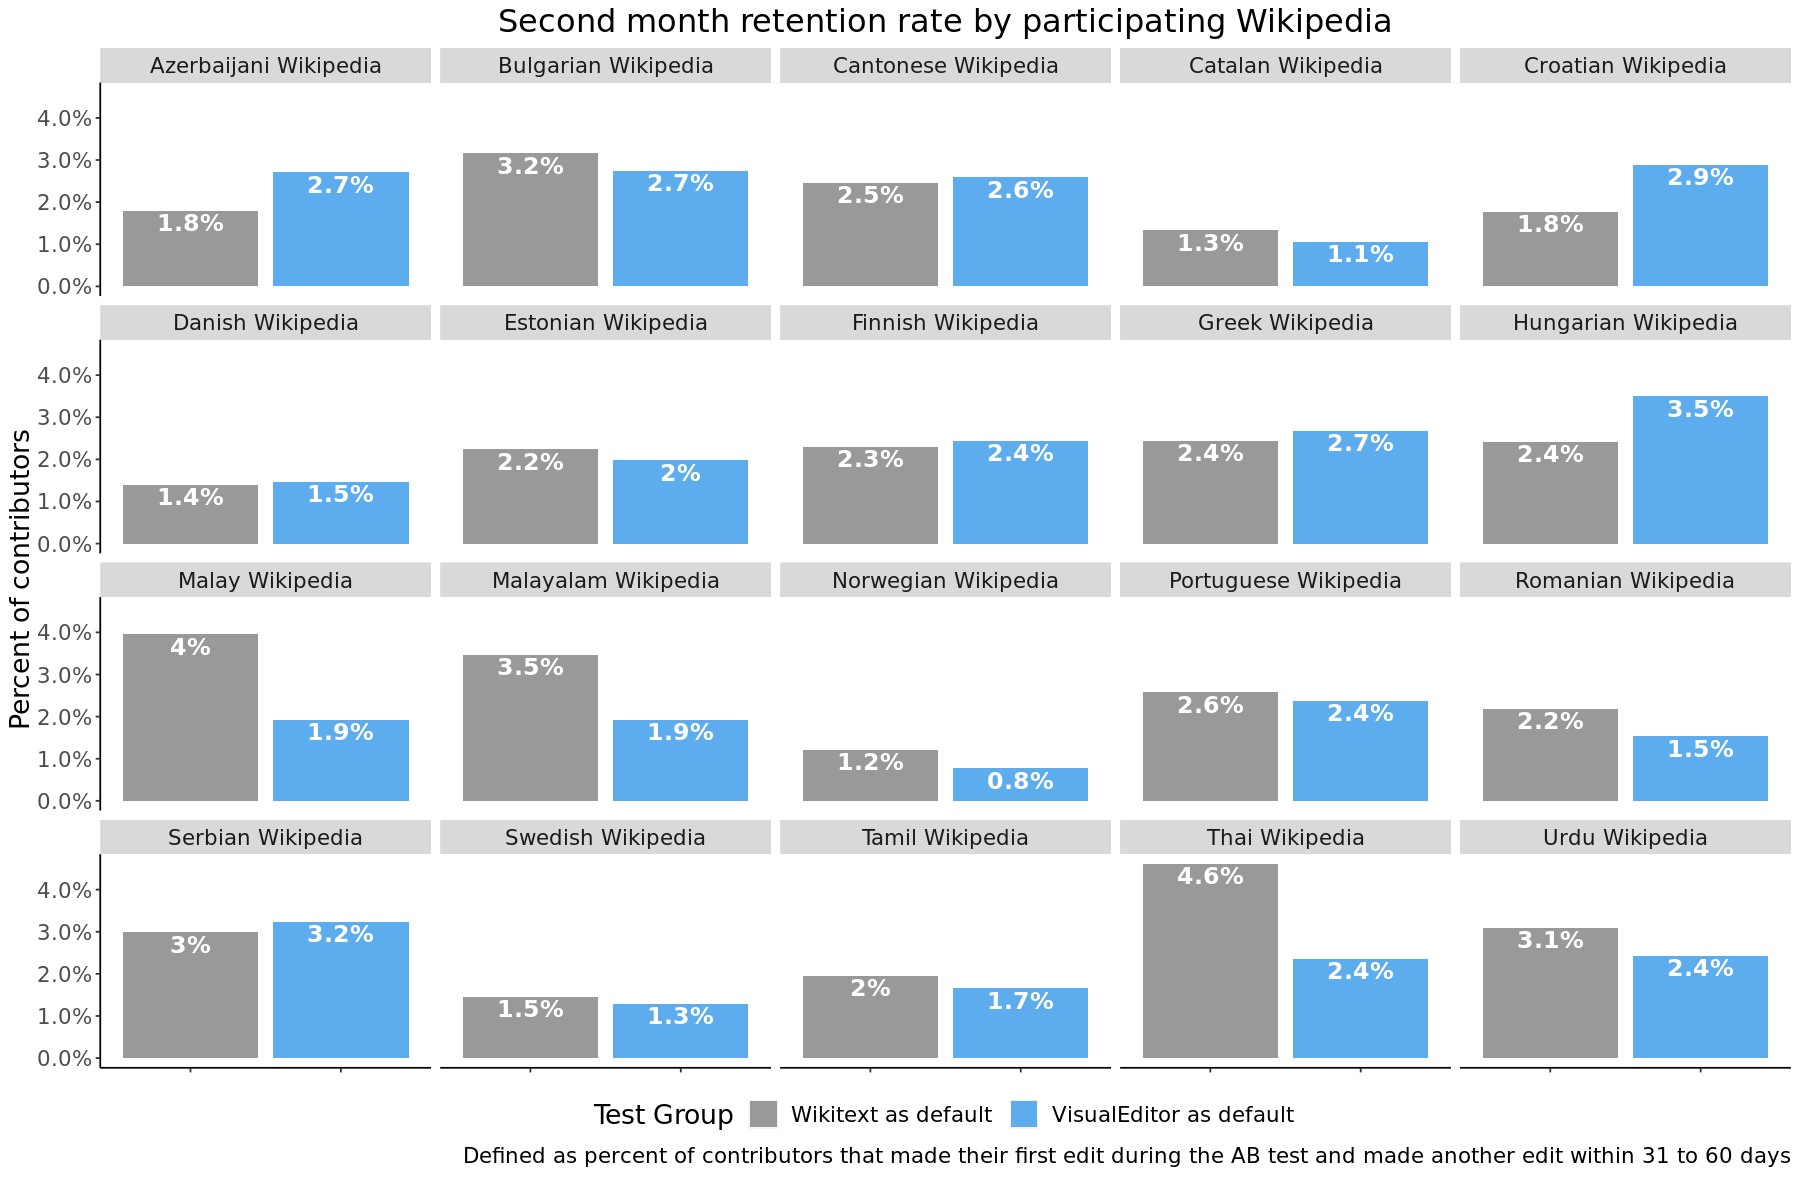

In [405]:
# Plot retention rates per wiki

dodge <- position_dodge(width=0.9)

p <- second_month_retention_bywiki  %>%
    ggplot(aes(x= bucket, y = return_editors / editors, fill = bucket)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(retention_rate), fontface=2), vjust=1.2, size = 5, color = "white") +
    facet_wrap(~ wiki) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of contributors ",
          title = "Second month retention rate by participating Wikipedia",
         caption = "Defined as percent of contributors that made their first edit during the AB test and made another edit within 31 to 60 days
")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Test Group")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/second_month_retention_bywiki_plot.png", p, width = 16, height = 8, units = "in", dpi = 300)

## Sixth Month Retention 

Defined as a user in the test making an edit to any namespace and returning between days 181-210. 
Data below only reflects registered users as we did not retain long-term data on logged-out users. 

In [406]:
# load in retention
sixth_month_retention_loggedin <-
  read.csv(
    file = 'Data/sixth_month_retention_loggedin.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) 


In [407]:
# set correct factor levels

sixth_month_retention_loggedin$bucket <-
  factor(
    sixth_month_retention_loggedin$bucket,
    levels = c('default-source', 'default-visual'),
    labels = c("Wikitext as default", "VisualEditor as default")
  )
#clarfiy wiki names
sixth_month_retention_loggedin <- sixth_month_retention_loggedin  %>%
  mutate(
    wiki = case_when(
      #clarfiy participating project names
        wiki == 'azwiki' ~ 'Azerbaijani Wikipedia', 
      wiki == 'bgwiki' ~ 'Bulgarian Wikipedia', 
      wiki == 'cawiki' ~ 'Catalan Wikipedia',  
      wiki == 'zh_yuewiki' ~ 'Cantonese Wikipedia', 
      wiki == 'hrwiki' ~ 'Croatian Wikipedia', 
      wiki == 'dawiki' ~ 'Danish Wikipedia', 
      wiki == 'etwiki' ~ 'Estonian Wikipedia', 
      wiki == 'fiwiki' ~ 'Finnish Wikipedia',    
      wiki == 'elwiki' ~ 'Greek Wikipedia', 
      wiki == 'huwiki' ~ 'Hungarian Wikipedia',
      wiki == 'mswiki' ~ 'Malay Wikipedia',
        wiki == 'mlwiki' ~ 'Malayalam Wikipedia',
        wiki == 'nowiki' ~ 'Norwegian Wikipedia',
        wiki == 'ptwiki' ~ 'Portuguese Wikipedia',
        wiki == 'rowiki' ~ 'Romanian Wikipedia',
        wiki == 'satwiki' ~ 'Santali Wikipedia',
        wiki == 'srwiki' ~ 'Serbian Wikipedia',
        wiki == 'svwiki' ~ 'Swedish Wikipedia',
        wiki == 'tawiki' ~ 'Tamil Wikipedia',
        wiki == 'thwiki' ~ 'Thai Wikipedia',
        wiki == 'urwiki' ~ 'Urdu Wikipedia'
))



### Overall

In [408]:
sixth_month_retention_loggedin_overall <- sixth_month_retention_loggedin %>%
    group_by(bucket)  %>%
    summarise(return_editors = sum(return_editors),
              editors = sum(editors),
        retention_rate = paste0(round(return_editors/editors * 100, 1), "%")) 
            


In [453]:
# Create table of retention rate
sixth_month_retention_loggedin_overall_table <- sixth_month_retention_loggedin_overall %>%
  gt() %>%
  tab_header(
    title = "Overall Sixth Month Retention Rate for Registered Contributors",
    subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    bucket = "Test Group",
    return_editors = "Number of returning editors",
    editors = "Number of editors",
    retention_rate = "Retention rate"
  ) %>% 
  tab_footnote(
    footnote = "Defined as percent of registered contributors that made their first edit during the AB test and made another edit within 181 to 210 days",
    locations = cells_column_labels(
      columns = 'retention_rate'
    )
  )  %>%
  tab_footnote(
    footnote = " Only includes registered editors",
    locations = cells_column_labels(
      columns = c('editors', 'return_editors')
    )
  )%>%
    gtsave(
    "sixth_month_retention_loggedin_overall_table.html", inline_css = TRUE)

IRdisplay::display_html(data = sixth_month_retention_loggedin_overall_table, file = "sixth_month_retention_loggedin_overall_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 Overall Sixth Month Retention Rate for Registered Contributors 
 
 
 across all participating Wikipedias 
 
 
 
 
 Test Group 
 Number of returning editors 1 
 Number of editors 1 
 Retention rate 2 
 
 
 
 
 Wikitext as default 
 298 
 29705 
 1% 
 
 
 VisualEditor as default 
 266 
 29833 
 0.9% 
 
 
 
 
 
 
 
 
 1 
 
 
 Only includes registered editors
 
 
 
 
 2 
 
 
 Defined as percent of registered contributors that made their first edit during the AB test and made another edit within 181 to 210 days

### By Participating Wikipedia

In [410]:
sixth_month_retention_loggedin_bywiki <- sixth_month_retention_loggedin %>%
    group_by(wiki, bucket)  %>%
    summarise(return_editors = sum(return_editors),
              editors = sum(editors),
        retention_rate = paste0(round(return_editors/editors * 100, 1), "%")) 
              

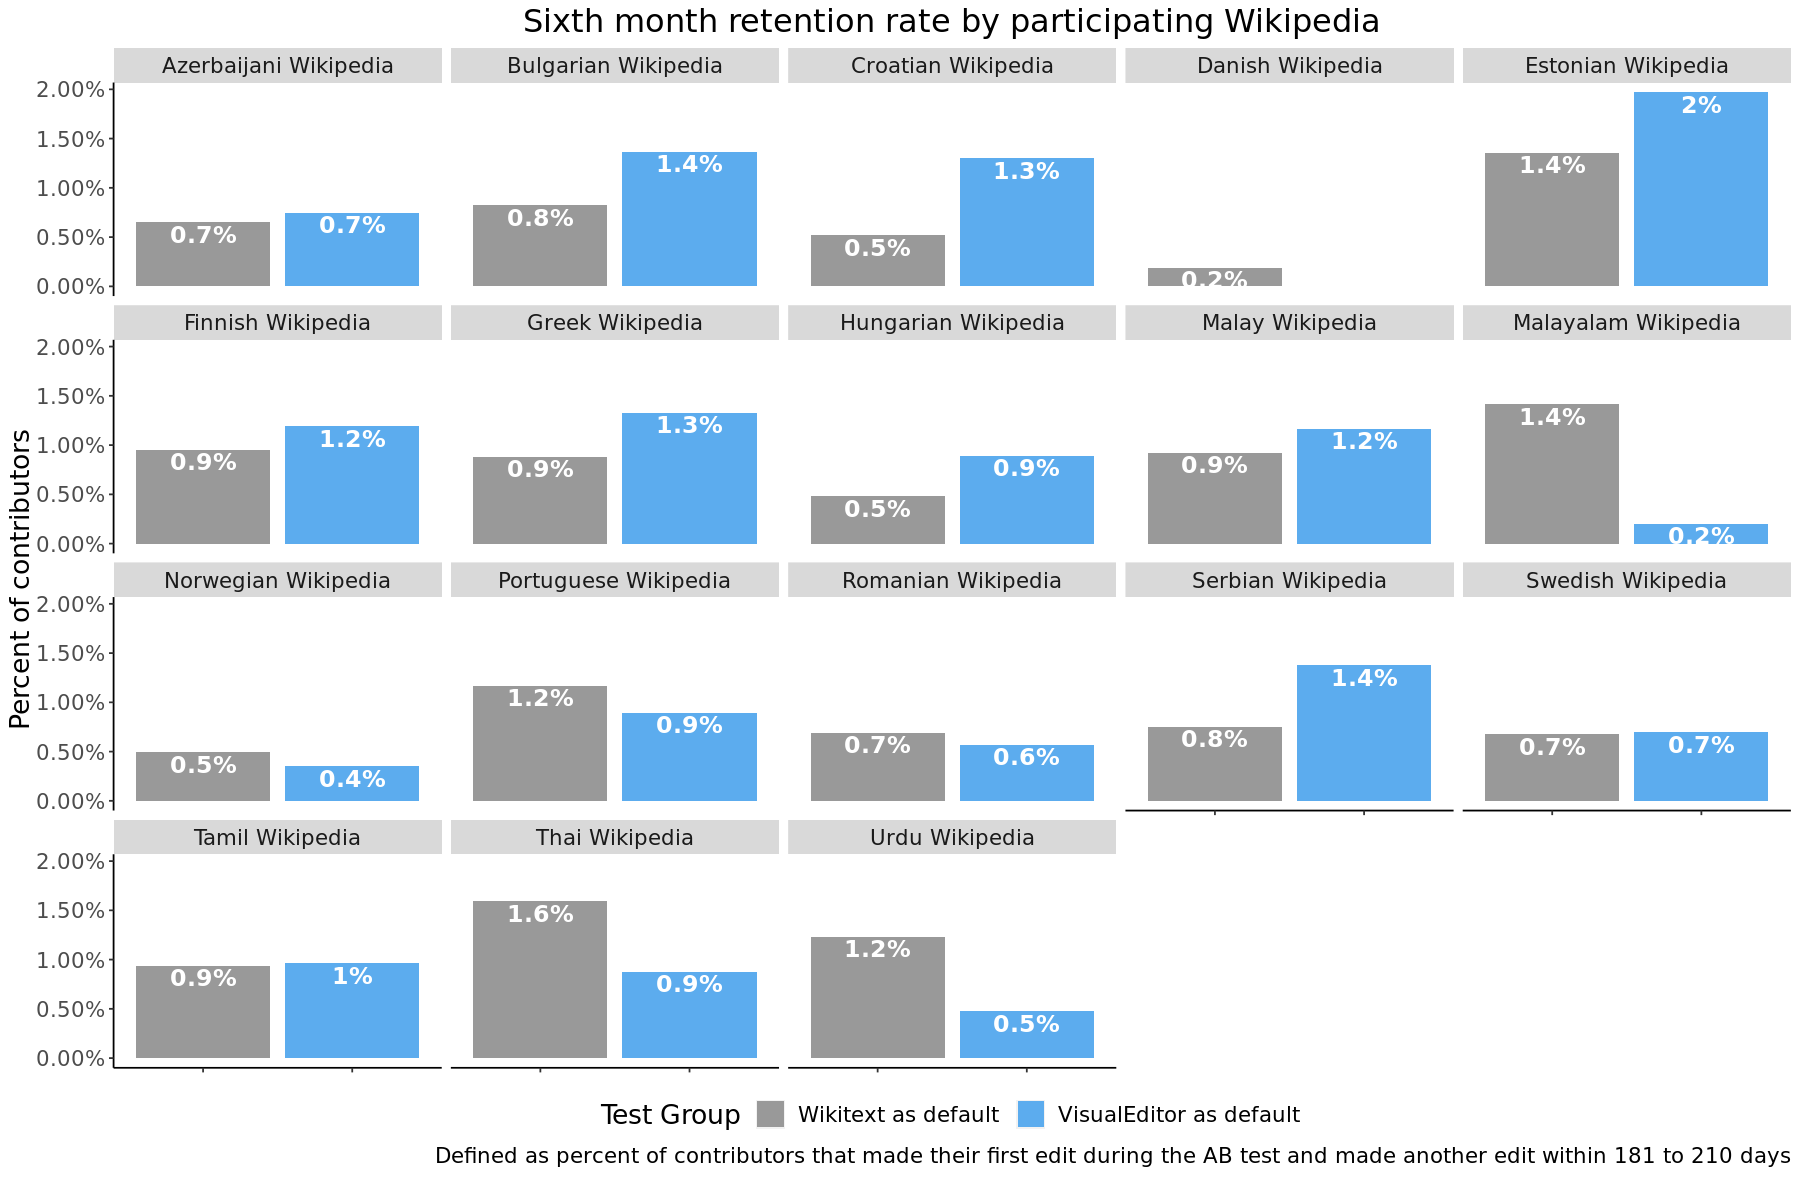

In [411]:
# Plot retention rates per wiki

dodge <- position_dodge(width=0.9)

p <- sixth_month_retention_loggedin_bywiki  %>%
    ggplot(aes(x= bucket, y = return_editors / editors, fill = bucket)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(retention_rate), fontface=2), vjust=1.2, size = 5, color = "white") +
    facet_wrap(~ wiki) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of contributors ",
          title = "Sixth month retention rate by participating Wikipedia",
         caption = "Defined as percent of contributors that made their first edit during the AB test and made another edit within 181 to 210 days
")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Test Group")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/sixth_month_retention_loggedin_bywiki_plot.png", p, width = 16, height = 8, units = "in", dpi = 300)

**Key Findings**

Overall retention rates across all three reviewed periods were similar (under 1 percentage point difference). We observed the following decreases in the retention rate of editors shown VisualEditor as default on mobile:

Second Week Retention: -15% (0.3 percentage points)
Second Month Retention: -8% (0.2 percentage points)
Sixth Month Retention: -10% (0.1 percentage points)

On a per wiki basis, results varied but retention rates were still very similar between the two editors. For the following wikis, we observed slightly higher overall retention rates for contributors that were shown VE as default on mobile: 
* Second Week Retention: Croatian, Danish, Estonian, Finnish, and Serbian. See figure below.
* Second Month Retention:  Azerbajijani, Cantonese, Croatian, Danish, Finnish, Greek, Hungarian, and Serbian
* Sixth Month Retention: Bulgarian, Croatian, Estonian, Finnish, Greek, Malay, and Serbian.


# Edit completion rate

We also reviewed edit completion rate, which we defined as the proportion of ready events that reach saveSuccess and are not reverted. Data was limited to edits on page main namespace.

For the purpose of this analysis, we reviewed data logged from the last 90 days of the AB test in editattemptstep. This was done to more directly compare logged-in and logged-out rates over the same period of time and because edit revert data was also available during this timeframe. We also compared these rates to long-term data retained to confirm there were no signficant changes in trends. 

In [22]:
# load in editor data.
# Dataset limited to time period that included available anon data
editor_data <-
  read.csv(
    file = 'Data/edit_attempts_withanon.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) 


In [23]:
#reformat and clean data

# add date column to easily sort data by edit time.
editor_data <- editor_data %>%
    mutate(date = as.Date(start_dt))

# set factor levels
editor_data$bucket <-
  factor(
    editor_data$bucket,
    levels = c('default-source', 'default-visual'),
    labels = c("Wikitext as default", "VisualEditor as default")
  )

# set factor levels
editor_data$user_is_anonymous <-
  factor(
    editor_data$user_is_anonymous,
    levels = c('True', 'False'),
    labels = c("Unregistered", "Registered")
  )


#clarfiy wiki names
editor_data <- editor_data %>%
  mutate(
    wiki = case_when(
      #clarfiy participating project names
      wiki == 'azwiki' ~ 'Azerbaijani Wikipedia', 
      wiki == 'bgwiki' ~ 'Bulgarian Wikipedia', 
      wiki == 'cawiki' ~ 'Catalan Wikipedia',  
      wiki == 'zh_yuewiki' ~ 'Cantonese Wikipedia', 
      wiki == 'hrwiki' ~ 'Croatian Wikipedia', 
      wiki == 'dawiki' ~ 'Danish Wikipedia', 
      wiki == 'etwiki' ~ 'Estonian Wikipedia', 
      wiki == 'fiwiki' ~ 'Finnish Wikipedia',    
      wiki == 'elwiki' ~ 'Greek Wikipedia', 
      wiki == 'huwiki' ~ 'Hungarian Wikipedia',
      wiki == 'mswiki' ~ 'Malay Wikipedia',
        wiki == 'mlwiki' ~ 'Malayalam Wikipedia',
        wiki == 'nowiki' ~ 'Norwegian Wikipedia',
        wiki == 'ptwiki' ~ 'Portuguese Wikipedia',
        wiki == 'rowiki' ~ 'Romanian Wikipedia',
        wiki == 'satwiki' ~ 'Santali Wikipedia',
        wiki == 'srwiki' ~ 'Serbian Wikipedia',
        wiki == 'svwiki' ~ 'Swedish Wikipedia',
        wiki == 'tawiki' ~ 'Tamil Wikipedia',
        wiki == 'thwiki' ~ 'Thai Wikipedia',
        wiki == 'urwiki' ~ 'Urdu Wikipedia'
))




## Overall

Overall edit completion rate across all participating Wikipedias. We also reviewed the data by if the edit was reverted within 48 hours or not to determine any difference in completion rates due to inclusion of reverted edits.

In [414]:
# Completion rate
pct_edits_completed_overall <- editor_data %>%
    group_by(bucket)  %>%
    summarize(n_edit_attempts = n_distinct(edit_attempt_id),
              includes_reverts = n_distinct(edit_attempt_id[edit_success == 'complete']),
               excludes_reverts = n_distinct(edit_attempt_id[edit_success == 'complete' & is_reverted == 'not-reverted']))%>%
    gather(key = "revert_status", value = "n_edits_saved", includes_reverts,  excludes_reverts) %>%
    arrange(bucket) %>%
    mutate(completion_rate = paste0(round(n_edits_saved/n_edit_attempts * 100, 2),"%"))


In [454]:
# Create table of edit completion rates
pct_edits_completed_overall_table <- pct_edits_completed_overall %>%
  mutate(revert_status =  factor(
    revert_status,
    levels = c('includes_reverts', 'excludes_reverts'),
    labels = c("Includes edits reverted", "Excludes edits reverted")
  ))  %>%
  gt(groupname_col = "revert_status") %>%
  tab_header(
    title = "Overall Edit Completion Rate for all Contributors",
    subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    bucket = "Test Group",
    n_edit_attempts = "Number of edit attempts",
    n_edits_saved = "Number of saved edits",
    completion_rate = "Completion rate"  
  )  %>%
  tab_footnote(
    footnote = "Defined as the the proportion of saved edits that are reverted within 48 hours",
    locations = cells_row_groups(
        groups = everything()
    )
  )  %>%
  tab_footnote(
    footnote = "Defined as the proportion of ready events that reach saveSuccess",
    locations = cells_column_labels(
      columns = 'completion_rate'
    )
  )%>%
    gtsave(
    "pct_edits_completed_overall_table .html", inline_css = TRUE)

IRdisplay::display_html(data = pct_edits_completed_overall_table , file = "pct_edits_completed_overall_table .html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 Overall Edit Completion Rate for all Contributors 
 
 
 across all participating Wikipedias 
 
 
 
 
 Test Group 
 Number of edit attempts 
 Number of saved edits 
 Completion rate 1 
 
 
 
 
 Includes edits reverted 2 
 
 
 Wikitext as default 
 320599 
 8838 
 2.76% 
 
 
 VisualEditor as default 
 199447 
 6145 
 3.08% 
 
 
 Excludes edits reverted 2 
 
 
 Wikitext as default 
 320599 
 6017 
 1.88% 
 
 
 VisualEditor as default 
 199447 
 3683 
 1.85% 
 
 
 
 
 
 
 
 
 1 
 
 
 Defined as the proportion of ready events that reach saveSuccess
 
 
 
 
 2 
 
 
 Defined as the the proportion of saved edits that are reverted within 48 hours

Edit completion rate trends vary depending on if reverted edits are included or excluded but we did not observe any significant differences.

Overall edit completion rate including edits that were reverted increased by 11.6% (0.3 percentage points) for users shown VE as the default editor. If we exclude any edits reverted, there were minimal change in the overall edit completion rate (-1.6% decrease [0.03 percentage points]).

## By Logged-in and Logged-Out

In [24]:
# Completion rate
pct_edits_completed_byanon <- editor_data %>%
    group_by(bucket, user_is_anonymous)  %>%
    summarize(n_edit_attempts = n_distinct(edit_attempt_id),
              includes_reverts = n_distinct(edit_attempt_id[edit_success == 'complete']),
               excludes_reverts = n_distinct(edit_attempt_id[edit_success == 'complete' & is_reverted == 'not-reverted']))%>%
    gather(key = "revert_status", value = "n_edits_saved", includes_reverts,  excludes_reverts) %>%
    arrange(bucket) %>%
    mutate(completion_rate = paste0(round(n_edits_saved/n_edit_attempts * 100, 2),"%"))


In [417]:
# Create table of edit completion rates
pct_edits_completed_loggedin_table <- pct_edits_completed_byanon %>%
  filter(user_is_anonymous == 'Registered') %>%
  select(-2) %>%  #only registered user data 
  mutate(revert_status =  factor(
    revert_status,
    levels = c('includes_reverts', 'excludes_reverts'),
    labels = c("Includes edits reverted", "Excludes edits reverted")
  ))  %>%
  gt(groupname_col = "revert_status") %>%
 tab_header(
    title = "Overall Edit Completion Rate for Registered Users ",
    subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    bucket = "Test Group",
    n_edit_attempts = "Number of edit attempts",
    n_edits_saved = "Number of saved edits",
    completion_rate = "Completion rate"  
  )  %>%
  tab_footnote(
    footnote = "Defined as the the proportion of saved edits that are reverted within 48 hours",
    locations = cells_row_groups(
        groups = everything()
    )
  )  %>%
  tab_footnote(
    footnote = "Defined as the proportion of ready events that reach saveSuccess",
    locations = cells_column_labels(
      columns = 'completion_rate'
    )
  )%>%
    gtsave(
    "pct_edits_completed_loggedin_table.html", inline_css = TRUE)

IRdisplay::display_html(data = pct_edits_completed_loggedin_table, file = "pct_edits_completed_loggedin_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 Overall Edit Completion Rate for Registered Users 
 
 
 across all participating Wikipedias 
 
 
 
 
 Test Group 
 Number of edit attempts 
 Number of saved edits 
 Completion rate 1 
 
 
 
 
 Includes edits reverted 2 
 
 
 Wikitext as default 
 6243 
 2215 
 35.48% 
 
 
 VisualEditor as default 
 5452 
 1884 
 34.56% 
 
 
 Excludes edits reverted 2 
 
 
 Wikitext as default 
 6243 
 1668 
 26.72% 
 
 
 VisualEditor as default 
 5452 
 1298 
 23.81% 
 
 
 
 
 
 
 
 
 1 
 
 
 Defined as the proportion of ready events that reach saveSuccess
 
 
 
 
 2 
 
 
 Defined as the the proportion of saved edits that are reverted within 48 hours

In [418]:
# Create table of edit completion rates
pct_edits_completed_loggedout_table <- pct_edits_completed_byanon %>%
  filter(user_is_anonymous == 'Unregistered') %>%
  select(-2) %>%  #only registered user data 
  mutate(revert_status =  factor(
    revert_status,
    levels = c('includes_reverts', 'excludes_reverts'),
    labels = c("Includes edits reverted", "Excludes edits reverted")
  ))  %>%
  gt(groupname_col = "revert_status") %>%
 tab_header(
    title = "Overall Edit Completion Rate for Unregistered Users ",
    subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    bucket = "Test Group",
    n_edit_attempts = "Number of edit attempts",
    n_edits_saved = "Number of saved edits",
    completion_rate = "Completion rate"  
  )  %>%
  tab_footnote(
    footnote = "Reverted edits are edits that are reverted within 48 hours",
    locations = cells_row_groups(
        groups = everything()
    )
  )  %>%
  tab_footnote(
    footnote = "Defined as the proportion of ready events that reach saveSuccess",
    locations = cells_column_labels(
      columns = 'completion_rate'
    )
  )%>%
    gtsave(
    "pct_edits_completed_loggedout_table .html", inline_css = TRUE)

IRdisplay::display_html(data = pct_edits_completed_loggedout_table, file = "pct_edits_completed_loggedout_table .html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 Overall Edit Completion Rate for Unregistered Users 
 
 
 across all participating Wikipedias 
 
 
 
 
 Test Group 
 Number of edit attempts 
 Number of saved edits 
 Completion rate 1 
 
 
 
 
 Includes edits reverted 2 
 
 
 Wikitext as default 
 314356 
 6623 
 2.11% 
 
 
 VisualEditor as default 
 193995 
 4261 
 2.2% 
 
 
 Excludes edits reverted 2 
 
 
 Wikitext as default 
 314356 
 4349 
 1.38% 
 
 
 VisualEditor as default 
 193995 
 2385 
 1.23% 
 
 
 
 
 
 
 
 
 1 
 
 
 Defined as the proportion of ready events that reach saveSuccess
 
 
 
 
 2 
 
 
 Reverted edits are edits that are reverted within 48 hours

We observed similar trends when we review registered and unregistered contributors separately.

For unregistered contributors,  all differences in edit completion rates between the two groups were under 1 percentage points. The edit completion rate is slightly higher for users shown VE as default when looking at all edits (4.3% increase [0.1 percentage point]). If we exclude edits reverted, then the edit completion rate for users shown VE decreased by 11% (0.15 percentage points)

For registered contributors, we observed slight decreases in edits completion rate by users shown VE as default when reverted edit are included or excluded from the calculation (-2.6% when reverted edit are included; -10.9% [-3 percentage points] when reverted edits are excluded).


## By Wikipedia

In [419]:
pct_edits_completed_bywiki <- editor_data %>%
    group_by(wiki, bucket)  %>%
    summarize(n_edit_attempts = n_distinct(edit_attempt_id),
              n_edits_saved = n_distinct(edit_attempt_id[edit_success == 'complete'& is_reverted == 'not-reverted']), #edits saved and not reverted
              completion_rate = paste0(round(n_edits_saved/n_edit_attempts * 100, 2),"%"))


In [420]:
# Plot retention rates per wiki

dodge <- position_dodge(width=0.9)

p <- pct_edits_completed_bywiki  %>%
    ggplot(aes(x= bucket, y = n_edits_saved / n_edit_attempts, fill = bucket)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(completion_rate), fontface=2), vjust=1.2, size = 5, color = "white") +
    facet_wrap(~ wiki) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of edits ",
          title = "Edit completion rate by participating Wikipedia",
         caption = "Defined as the proportion of ready events that reach saveSuccess and are not reverted")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Test Group")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/pct_edits_completed_bywiki_plot.png", p, width = 16, height = 8, units = "in", dpi = 300)

Results vary on a per Wikipedia basis. Cantonese Wikipedia and Malay Wikipedia had significantly higher edit completion rates for users shown wikitext as default, while Portuguese Wikipedia had a higher edit completion rate for users shown VE as default. For all other participating Wikipedias, there were only slight differences in edit completion rate

# Proportion of editors who make at least 1 successful edit

Defined as the proportion of distinct editors that make an edit attempt  (event.action = ‘ready’) and successfully complete at least 1 edit  (event.action = ‘saveSuccess’ that is not reverted within 48 hours.

## Overall

In [421]:
pct_users_completed <- editor_data %>%
    group_by(bucket)  %>%
    summarize(n_users_attempted = n_distinct(user_id),
              n_users_completed = n_distinct(user_id[edit_success == 'complete' & is_reverted == 'not-reverted']), #edits saved and not reverted
              completion_rate = paste0(round(n_users_completed/n_users_attempted * 100, 2),"%"))



In [422]:
# Create table of edit completion rates
pct_users_completed_table <- pct_users_completed %>%
 gt() %>%
  tab_header(
    title = "Proportion of editors who make at least 1 successful edit",
    subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    bucket = "Test Group",
    n_users_attempted = "Number of editors that made an edit attempt",
    n_users_completed = "Number of editors that saved an edit",
    completion_rate = "Completion rate"  
  )    %>%
  tab_footnote(
    footnote = "Defined as the proportion of distinct editors that made an edit that was not reverted",
    locations = cells_column_labels(
      columns = 'completion_rate'
    )
  )%>%
    gtsave(
    "pct_users_completed_table.html", inline_css = TRUE)

IRdisplay::display_html(data = pct_users_completed_table , file = "pct_users_completed_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 Proportion of editors who make at least 1 successful edit 
 
 
 across all participating Wikipedias 
 
 
 
 
 Test Group 
 Number of editors that made an edit attempt 
 Number of editors that saved an edit 
 Completion rate 1 
 
 
 
 
 Wikitext as default 
 252968 
 2346 
 0.93% 
 
 
 VisualEditor as default 
 162291 
 2176 
 1.34% 
 
 
 
 
 
 
 
 
 1 
 
 
 Defined as the proportion of distinct editors that made an edit that was not reverted

Users that were shown VE as default were slightly more likely to make at least 1 successful edit that was not reverted during the AB test.  There was a 44% increase (0.41 percentage point) in the percent of distinct users that were able to complete at least 1 mobile edit when VE was shown as the default editor.

## By Logged-In and Logged-Out

In [423]:
pct_users_completed_byanon <- editor_data %>%
    group_by(bucket, user_is_anonymous)  %>%
    summarize(n_users_attempted = n_distinct(user_id),
              n_users_completed = n_distinct(user_id[edit_success == 'complete'& is_reverted == 'not-reverted']), #edits saved and not reverted
              completion_rate = paste0(round(n_users_completed/n_users_attempted * 100, 2),"%"))


In [424]:
# Create table of edit completion rates
pct_users_completed_byanon_table <- pct_users_completed_byanon %>%
 gt(groupname_col = "user_is_anonymous") %>%
  tab_header(
    title = "Proportion of editors who make at least 1 successful edit",
    subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    bucket = "Test Group",
    n_users_attempted = "Number of editors that made an edit attempt",
    n_users_completed = "Number of editors that saved an edit",
    completion_rate = "Completion rate"  
  )    %>%
  tab_footnote(
    footnote = "Defined as the proportion of distinct editors that made an edit that was not reverted",
    locations = cells_column_labels(
      columns = 'completion_rate'
    )
  )%>%
    gtsave(
    "pct_users_completed_byanon_table.html", inline_css = TRUE)

IRdisplay::display_html(data = pct_users_completed_byanon_table , file = "pct_users_completed_byanon_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 Proportion of editors who make at least 1 successful edit 
 
 
 across all participating Wikipedias 
 
 
 
 
 Test Group 
 Number of editors that made an edit attempt 
 Number of editors that saved an edit 
 Completion rate 1 
 
 
 
 
 Unregistered 
 
 
 Wikitext as default 
 250968 
 1647 
 0.66% 
 
 
 VisualEditor as default 
 160410 
 1480 
 0.92% 
 
 
 Registered 
 
 
 Wikitext as default 
 2000 
 699 
 34.95% 
 
 
 VisualEditor as default 
 1881 
 696 
 37% 
 
 
 
 
 
 
 
 
 1 
 
 
 Defined as the proportion of distinct editors that made an edit that was not reverted

We also increases in the proportion of both registered and unregistered editors who were able to successfully save at least 1 edit when shown VE as the default editor. 
* Registered editors: 6% increase [2 percentage points])  
* Unregistered editors: 39% increase [0.3 percentage points]


## By Participating Wikipedia

In [425]:
pct_users_completed_bywiki <- editor_data %>%
    group_by(wiki, bucket)  %>%
    summarize(n_users_attempted = n_distinct(user_id),
              n_users_completed = n_distinct(user_id[edit_success == 'complete'& is_reverted == 'not-reverted']), #edits saved and not reverted
              completion_rate = paste0(round(n_users_completed/n_users_attempted * 100, 2),"%"))


In [426]:
# Plot completion rates per wiki

dodge <- position_dodge(width=0.9)

p <- pct_users_completed_bywiki  %>%
    ggplot(aes(x= bucket, y = n_users_completed / n_users_attempted , fill = bucket)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(completion_rate), fontface=2), vjust=1.2, size = 5, color = "white") +
    facet_wrap(~ wiki) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of editors ",
          title = "Proportion of editors who make at least 1 successful edit",
         caption = "Defined as the proportion of distinct editors that made an edit that was not reverted")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Test Group")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/ pct_edits_completed_bywiki _plot.png", p, width = 16, height = 8, units = "in", dpi = 300)

We observed slight increases in the proportion of editors that saved at least 1 edit on each participating Wikipedia, with more a significant increase observed on Portuguese Wikipedia. We only observed the reverse trend on Cantonese Wikipedia, where a there was a higher proportion of editors that saved at least 1 edit when using wikitext as default.

# Edit quality

We also reviewed the percent of published edits reverted within 48 hours as an indicator of edit quality.

## Overall

In [427]:
pct_edits_reverted <- editor_data %>%
    filter(edit_success == 'complete')  %>% # only published edits
    group_by(bucket)  %>%
    summarize(n_edits = n_distinct(edit_attempt_id),
              n_edits_reverted = n_distinct(edit_attempt_id[is_reverted == 'reverted']), #edits saved and not reverted
              revert_rate = paste0(round(n_edits_reverted/n_edits * 100, 2),"%"))


In [428]:
# Create table of edit completion rates
pct_edits_reverted_table <- pct_edits_reverted %>%
 gt() %>%
  tab_header(
    title = "Proportion of saved edits reverted within 48 hours",
    subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    bucket = "Test Group",
    n_edits = "Number of edits saved",
    n_edits_reverted = "Number of edits reverted",
    revert_rate = "Revert rate"  
  )%>%
    gtsave(
    "pct_edits_reverted_table.html", inline_css = TRUE)

IRdisplay::display_html(data = pct_edits_reverted_table , file = "pct_edits_reverted_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 Proportion of saved edits reverted within 48 hours 
 
 
 across all participating Wikipedias 
 
 
 
 
 Test Group 
 Number of edits saved 
 Number of edits reverted 
 Revert rate 
 
 
 
 
 Wikitext as default 
 8838 
 2821 
 31.92% 
 
 
 VisualEditor as default 
 6145 
 2462 
 40.07%

Revert rates are higher for users shown VE as default, overall and for registered and unregistered editors. This difference (25.5% increase [8 percentage points]) is generally consistent with the difference in revert rates found for the two editing interfaces on desktop. See T259196#6374218.

## By Logged-In and Logged-Out

In [429]:
pct_edits_reverted_byanon <- editor_data %>%
    filter(edit_success == 'complete')  %>%
    group_by(bucket, user_is_anonymous)  %>%
    summarize(n_edits = n_distinct(edit_attempt_id),
              n_edits_reverted = n_distinct(edit_attempt_id[is_reverted == 'reverted']), #edits saved and  reverted
                revert_rate = paste0(round(n_edits_reverted/n_edits * 100, 2),"%"))


In [430]:
# Create table of edit completion rates
pct_edits_reverted_byanon_table <- pct_edits_reverted_byanon %>%
 gt(groupname_col = "user_is_anonymous") %>%
  tab_header(
    title = "Proportion of saved edits reverted within 48 hours by logged in status",
    subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    bucket = "Test Group",
    n_edits = "Number of edits saved",
    n_edits_reverted = "Number of edits reverted",
    revert_rate = "Revert rate"  
  )%>%
    gtsave(
    "pct_edits_reverted_byanon_table.html", inline_css = TRUE)

IRdisplay::display_html(data = pct_edits_reverted_byanon_table , file = "pct_edits_reverted_byanon_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 Proportion of saved edits reverted within 48 hours by logged in status 
 
 
 across all participating Wikipedias 
 
 
 
 
 Test Group 
 Number of edits saved 
 Number of edits reverted 
 Revert rate 
 
 
 
 
 Unregistered 
 
 
 Wikitext as default 
 6623 
 2274 
 34.33% 
 
 
 VisualEditor as default 
 4261 
 1876 
 44.03% 
 
 
 Registered 
 
 
 Wikitext as default 
 2215 
 547 
 24.7% 
 
 
 VisualEditor as default 
 1884 
 586 
 31.1%

This same trend is also found when results are broken down by registered and unregistered editors. Specific increases are noted below:
* Registered Editors: 26% increase [6.4 percentage points]
* Unregistered Editors: 28% increase [9.7 percentage points]


## By Wiki

In [431]:
pct_edits_reverted_bywiki <- editor_data %>%
    filter(edit_success == 'complete')  %>%
    group_by(wiki, bucket)  %>%
    summarize(n_edits = n_distinct(edit_attempt_id),
              n_edits_reverted = n_distinct(edit_attempt_id[is_reverted == 'reverted']), #edits saved and reverted
              revert_rate = paste0(round(n_edits_reverted/n_edits * 100, 2),"%"))


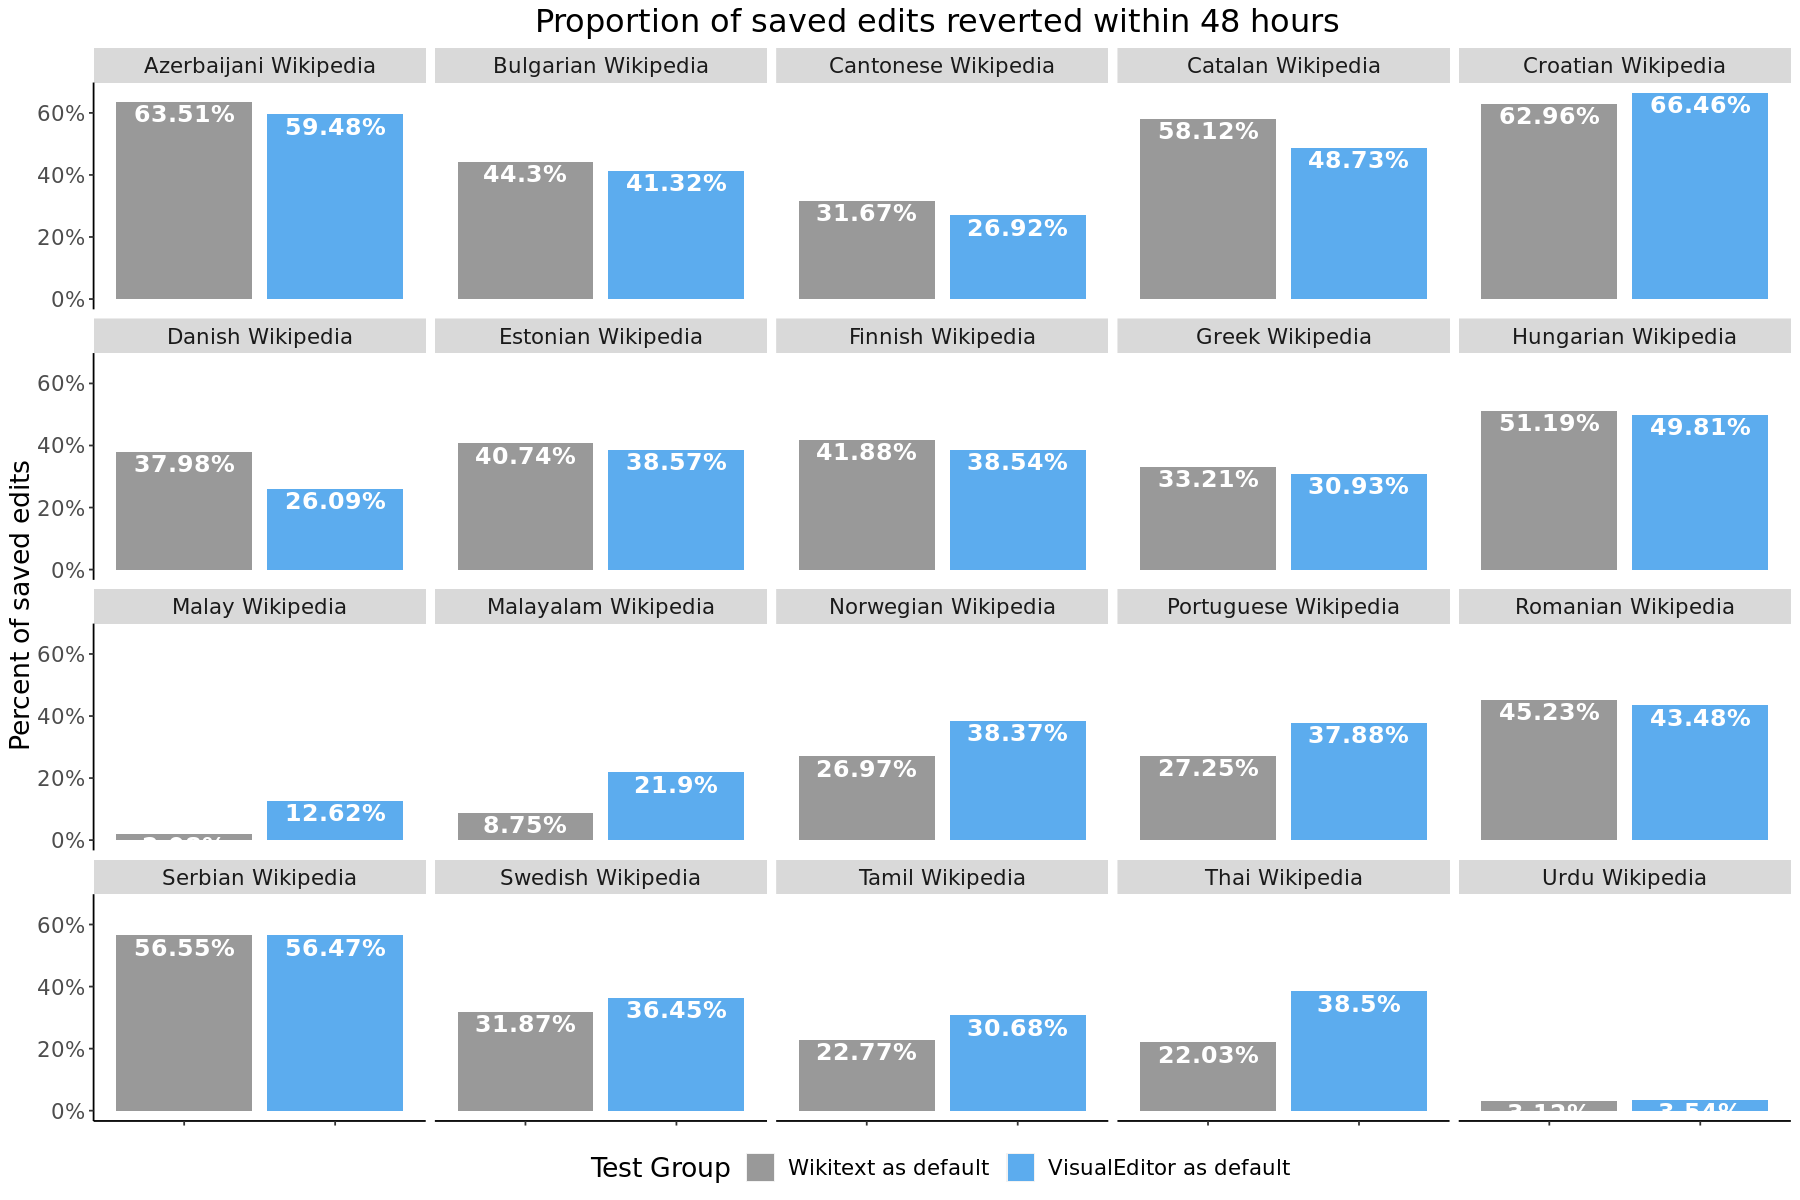

In [432]:
# Plot revert rates per wiki

dodge <- position_dodge(width=0.9)

p <- pct_edits_reverted_bywiki  %>%
    ggplot(aes(x= bucket, y = n_edits_reverted / n_edits , fill = bucket)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(revert_rate), fontface=2), vjust=1.2, size = 5, color = "white") +
    facet_wrap(~ wiki) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of saved edits ",
          title = "Proportion of saved edits reverted within 48 hours ")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Test Group")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/pct_edits_reverted_bywiki_plot.png", p, width = 16, height = 8, units = "in", dpi = 300)

Results vary on a per wikipedia basis with 10 participating wikis such as Bulgarian, Cantonese, Catalan, Danish, Estonian, and Finishe Wikipedia having slightly lower revert rates by users shown VE as default. 

# Disruption

Definition: The percentage of edits completed in an editing interface that is not the one they were shown by default.

Reviewed Timeframe: July through September 2022 (Verified trends with long term data as well)


In [462]:
# add column to indicate if default editor was used
editor_data <- editor_data  %>%
    mutate(default_editor_used = 
           case_when (
            ((bucket == 'Wikitext as default' & save_interface == 'visualeditor')|
             (bucket == 'VisualEditor as default' & save_interface == 'wikitext'))  ~  "non-default editor used",
            ((bucket == 'Wikitext as default' & save_interface == 'wikitext')|
             (bucket == 'VisualEditor as default' & save_interface == 'visualeditor'))  ~  "default editor used"
               ))
           

## Overall

In [473]:
pct_edits_nondefault_editor <- editor_data %>%
    filter(edit_success == 'complete')  %>% # only saved edits
    group_by(bucket)  %>%
    summarize(n_nondefault_edits = n_distinct(edit_attempt_id[default_editor_used == 'non-default editor used']),
              n_edits = n_distinct(edit_attempt_id),
             pct_edits_nondefault = paste0(round(n_nondefault_edits/n_edits * 100, 2),"%"))


In [474]:
# Create table of editor swtich rates by logged in status
pct_edits_nondefault_editor_table  <- pct_edits_nondefault_editor %>%
  gt() %>%
  tab_header(
    title = "Proportion  of edits completed in an editing interface that was not shown by default",
    subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    bucket = "Test Group",
    n_nondefault_edits = "Number of edits saved with nondefault editor",
    n_edits= "Number of edits saved",
    pct_edits_nondefault = "Proportion of edits saved with nondefault editor"  
  )%>%
    gtsave(
    "pct_edits_nondefault_editor_table.html", inline_css = TRUE)

IRdisplay::display_html(data = pct_edits_nondefault_editor_table , file = "pct_edits_nondefault_editor_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 Proportion of edits completed in an editing interface that was not shown by default 
 
 
 across all participating Wikipedias 
 
 
 
 
 Test Group 
 Number of edits saved with nondefault editor 
 Number of edits saved 
 Proportion of edits saved with nondefault editor 
 
 
 
 
 Wikitext as default 
 236 
 8838 
 2.67% 
 
 
 VisualEditor as default 
 206 
 6145 
 3.35%

Overall there was a 25% increase (0.7 percentage points) in the percentage of edits completed in a non-default editing interface when VisualEditor was shown as the default.

## By Logged In and Logged Out

In [436]:
pct_edits_nondefault_editor_byanon <- editor_data %>%
    filter(edit_success == 'complete')  %>% # only saved edits
    group_by(user_is_anonymous, bucket)  %>%
    summarize(n_nondefault_edits = n_distinct(edit_attempt_id[default_editor_used == 'non-default editor used']),
              n_edits = n_distinct(edit_attempt_id),
             pct_edits_nondefault = paste0(round(n_nondefault_edits/n_edits * 100, 2),"%"))


In [437]:
# Create table of editor swtich rates by logged in status
pct_edits_nondefault_editor_byanon_table  <- pct_edits_nondefault_editor_byanon %>%
 gt(groupname_col = "user_is_anonymous") %>%
  tab_header(
    title = "Proportion  of edits completed in an editing interface that was not shown by default",
    subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    bucket = "Test Group",
    n_nondefault_edits = "Number of edits saved with nondefault editor",
    n_edits= "Number of edits saved",
    pct_edits_nondefault = "Proportion of edits saved with nondefault editor"  
  )%>%
    gtsave(
    "pct_edits_nondefault_editor_byanon_table.html", inline_css = TRUE)

IRdisplay::display_html(data = pct_edits_nondefault_editor_byanon_table , file = "pct_edits_nondefault_editor_byanon_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 Proportion of edits completed in an editing interface that was not shown by default 
 
 
 across all participating Wikipedias 
 
 
 
 
 Test Group 
 Number of edits saved with nondefault editor 
 Number of edits saved 
 Proportion of edits saved with nondefault editor 
 
 
 
 
 Unregistered 
 
 
 Wikitext as default 
 14 
 6623 
 0.21% 
 
 
 VisualEditor as default 
 77 
 4261 
 1.81% 
 
 
 Registered 
 
 
 Wikitext as default 
 222 
 2215 
 10.02% 
 
 
 VisualEditor as default 
 129 
 1884 
 6.85%

When broken down by logged in status, the trends differ. Registered users shown VE as default switched editors less frequently than users shown Wikitext as default while the reverse trend was observed for unregistered editors. Specific changes noted below:
* Registered editors:  -31.6% decrease [-3.2 percentage points]
* Unregistered editors: 1.6 percentage point increase


## By Wiki

In [438]:
pct_edits_nondefault_editor_bywiki <- editor_data %>%
    filter(edit_success == 'complete')  %>% # only saved edits
    group_by(wiki, bucket)  %>%
    summarize(n_nondefault_edits = n_distinct(edit_attempt_id[default_editor_used == 'non-default editor used']),
              n_edits = n_distinct(edit_attempt_id),
             pct_edits_nondefault = paste0(round(n_nondefault_edits/n_edits * 100, 2),"%"))


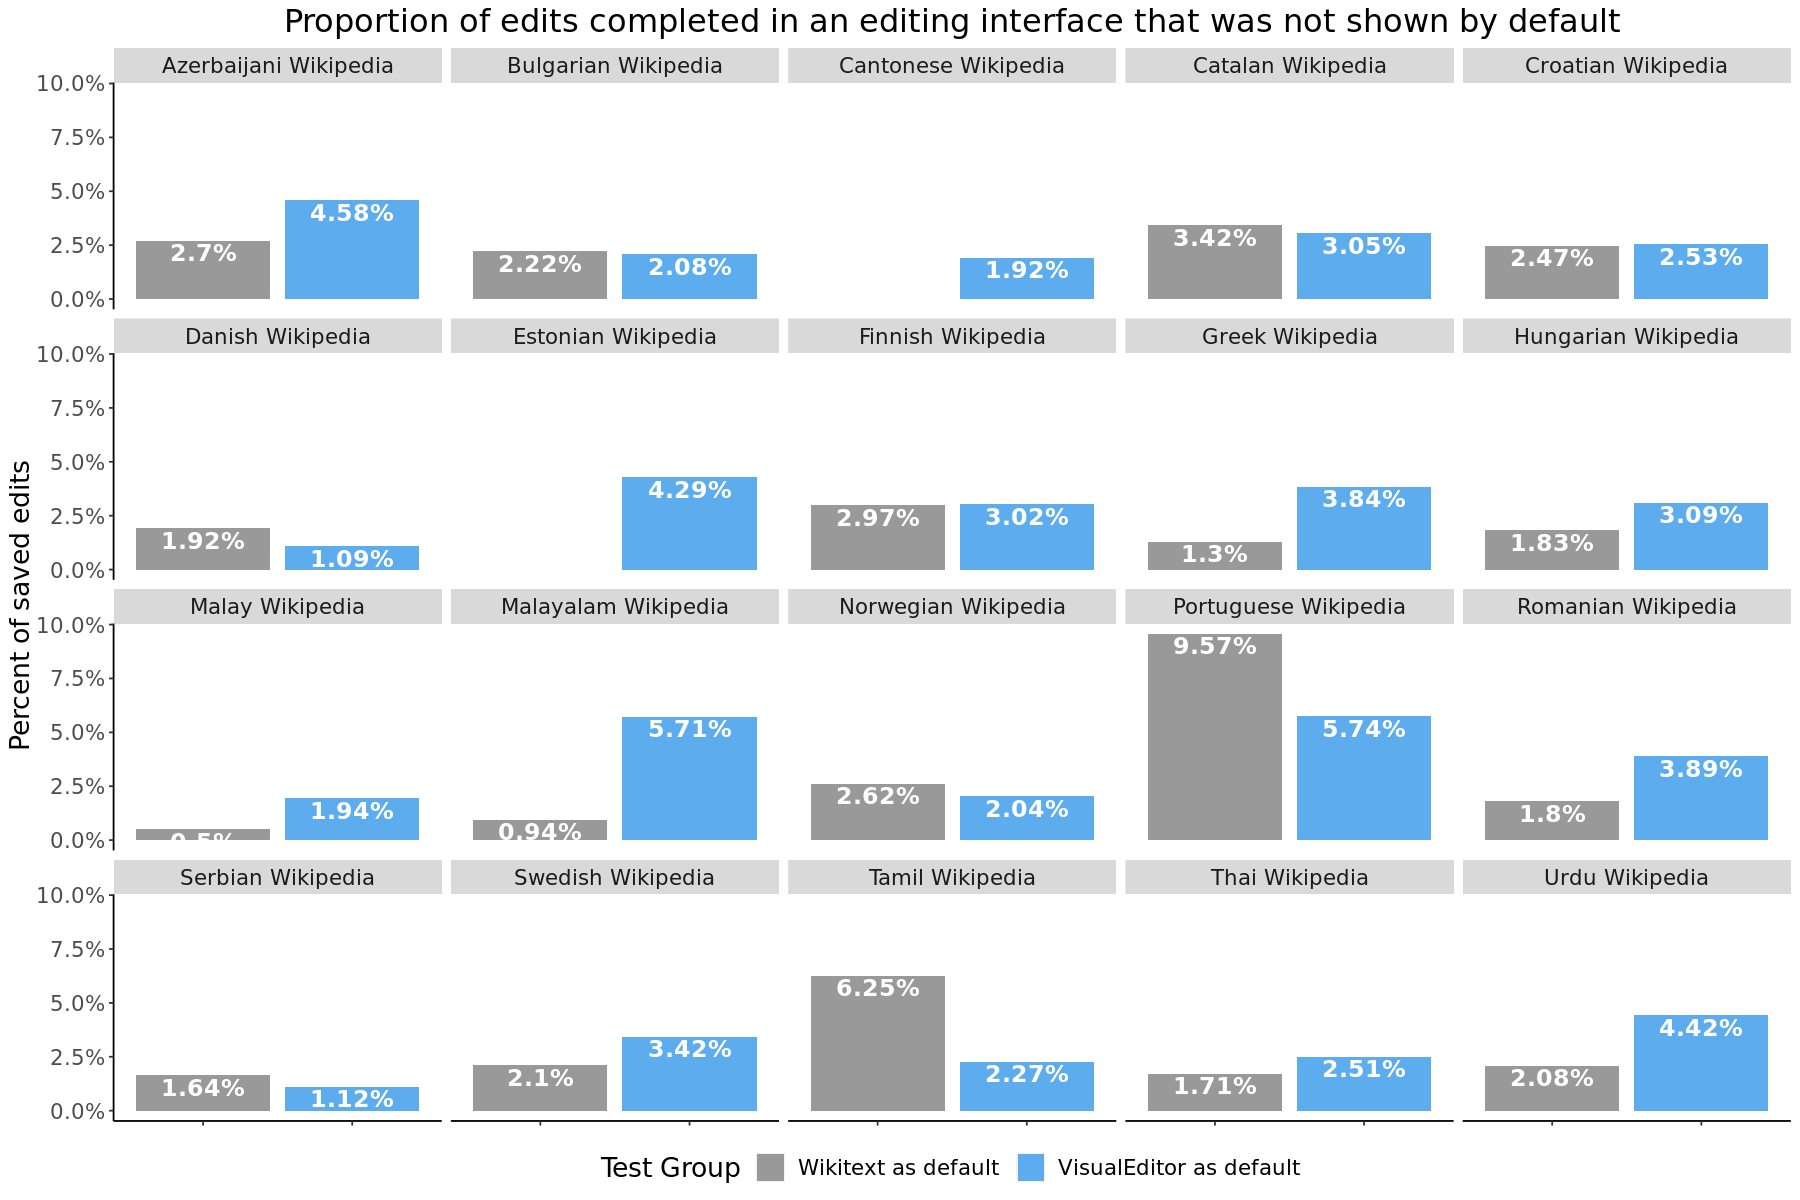

In [439]:

dodge <- position_dodge(width=0.9)

p <- pct_edits_nondefault_editor_bywiki  %>%
    ggplot(aes(x= bucket, y = n_nondefault_edits / n_edits , fill = bucket)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(pct_edits_nondefault), fontface=2), vjust=1.2, size = 5, color = "white") +
    facet_wrap(~ wiki) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of saved edits ",
          title = "Proportion of edits completed in an editing interface that was not shown by default")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Test Group")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/pct_edits_nondefault_editor_bywiki_plot.png", p, width = 16, height = 8, units = "in", dpi = 300)

Results again vary on a per wikipedia basis. We observed a lower proportion of editing sessions completed using in a non-default editor when shown VE as default on the following 7 participating wikis: Bulgarian, Catalan, Danish, Norwegian, Portuguese, Serbian and Tamil Wikipedia. 

# Total number of completed edits

We also looked at the total number of edits and distinct users that were successfully published. Note: Events included in this AB test were sampled at 100% so they should reflect an accurate total number of edits that occurred in the AB test.

Note: Data reflects all events logged during the AB Test from November 2019 through September 2022.


In [ ]:
# load in full edit dataset
edit_attempts_full <-
  read.csv(
    file = 'Data/edit_completion_fulldata.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) 


In [ ]:
# set factor levels
edit_attempts_full$user_is_anonymous <-
  factor(
   edit_attempts_full$user_is_anonymous,
    levels = c('anon', 'registered'),
    labels = c("Unregistered", "Registered")
  )



edit_attempts_full$bucket <-
  factor(
    second_week_retention_all$bucket,
    levels = c('default-source', 'default-visual'),
    labels = c("Wikitext as default", "VisualEditor as default")
  )

#clarfiy wiki names
edit_attempts_full <- edit_attempts_full%>%
  mutate(
    wiki = case_when(
      #clarfiy participating project names
      wiki == 'azwiki' ~ 'Azerbaijani Wikipedia', 
      wiki == 'bgwiki' ~ 'Bulgarian Wikipedia', 
      wiki == 'cawiki' ~ 'Catalan Wikipedia',  
      wiki == 'zh_yuewiki' ~ 'Cantonese Wikipedia', 
      wiki == 'hrwiki' ~ 'Croatian Wikipedia', 
      wiki == 'dawiki' ~ 'Danish Wikipedia', 
      wiki == 'etwiki' ~ 'Estonian Wikipedia', 
      wiki == 'fiwiki' ~ 'Finnish Wikipedia',    
      wiki == 'elwiki' ~ 'Greek Wikipedia', 
      wiki == 'huwiki' ~ 'Hungarian Wikipedia',
      wiki == 'mswiki' ~ 'Malay Wikipedia',
        wiki == 'mlwiki' ~ 'Malayalam Wikipedia',
        wiki == 'nowiki' ~ 'Norwegian Wikipedia',
        wiki == 'ptwiki' ~ 'Portuguese Wikipedia',
        wiki == 'rowiki' ~ 'Romanian Wikipedia',
        wiki == 'satwiki' ~ 'Santali Wikipedia',
        wiki == 'srwiki' ~ 'Serbian Wikipedia',
        wiki == 'svwiki' ~ 'Swedish Wikipedia',
        wiki == 'tawiki' ~ 'Tamil Wikipedia',
        wiki == 'thwiki' ~ 'Thai Wikipedia',
        wiki == 'urwiki' ~ 'Urdu Wikipedia'
))


## Overall

In [442]:
num_edits_completed <- edit_attempts_full %>%
    group_by(bucket)  %>%
    summarize(n_attempts = sum(edit_attempts),
              n_edits_saved = sum(saved_edits),
             n_users_saved = n_distinct(user_id[saved_edits > 0]))


In [444]:
# Create table of total completed edits
num_edits_complete_table <- num_edits_completed %>%
  gt() %>%
  tab_header(
    title = "Total number of saved edits and distinct registered users that completed an edit",
    subtitle = "across all participating Wikipedias from November 2019 through September 2022"
  )  %>%
  cols_label(
    bucket = "Test Group",
    n_attempts = "Number of edit attempts",
    n_edits_saved = "Number of saved edits",
    n_users_saved = "Number of registered users that saved an edit"
  )  %>%
    gtsave(
    "num_edits_complete_table.html", inline_css = TRUE)

IRdisplay::display_html(data = num_edits_complete_table , file = "num_edits_complete_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 Total number of saved edits and distinct registered users that completed an edit 
 
 
 across all participating Wikipedias from November 2019 through September 2022 
 
 
 
 
 Test Group 
 Number of edit attempts 
 Number of saved edits 
 Number of registered users that saved an edit 
 
 
 
 
 default-source 
 27569365 
 745557 
 55137 
 
 
 default-visual 
 17201959 
 555068 
 57365

There were fewer saved edits by users shown VE as default (-25.6% decrease)  but more distinct registered users (4% increase) that saved an edit. 

## By Logged-In and Logged-Out

In [445]:
num_edits_completed_byanon <- edit_attempts_full %>%
    group_by(bucket, user_is_anonymous)  %>%
    summarize(n_attempts = sum(edit_attempts),
              n_edits_saved = sum(saved_edits))


In [446]:
# Create table of edit completion rates
num_edits_complete_byanon_table <- num_edits_completed_byanon %>%
  gt(groupname_col = "user_is_anonymous") %>%
  tab_header(
    title = "Total number of saved edits by logged in status",
    subtitle = "across all participating Wikipedias from Noember 2019 through September 2022"
  )  %>%
  cols_label(
  bucket = "Test Group",
    n_attempts = "Number of edit attempts",
    n_edits_saved = "Number of saved edits"
  )%>%
    gtsave(
    "num_edits_complete_byanon_table.html", inline_css = TRUE)

IRdisplay::display_html(data =num_edits_complete_byanon_table  , file = "num_edits_complete_byanon_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 Total number of saved edits by logged in status 
 
 
 across all participating Wikipedias from Noember 2019 through September 2022 
 
 
 
 
 Test Group 
 Number of edit attempts 
 Number of saved edits 
 
 
 
 
 Unregistered 
 
 
 default-source 
 27057524 
 569513 
 
 
 default-visual 
 16750063 
 403577 
 
 
 Registered 
 
 
 default-source 
 511841 
 176044 
 
 
 default-visual 
 451896 
 151491

TWe observed decreases in the total number of saved edits by both registered and unregistered users. Specific changes are noted below:
Registered: - 14% decrease
Unregistered: -29% decrease


## By Wiki

In [447]:
num_edits_completed_bywiki <- edit_attempts_full %>%
    group_by(bucket, wiki)  %>%
    summarize(n_attempts = sum(edit_attempts),
              n_edits_saved = sum(saved_edits),
              n_users_saved = n_distinct(user_id[saved_edits > 0]))

In [455]:
dodge <- position_dodge(width=0.9)

p <- num_edits_completed_bywiki  %>%
    ggplot(aes(x= bucket, y = n_edits_saved , fill = bucket)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(n_edits_saved), fontface=2), vjust=1.2, size = 5, color = "white") +
    facet_wrap(~ wiki) +
    scale_y_continuous() +
    labs (y = "Number of saved edits ",
          title = "Total number of edits saved \n by participating Wikipedia")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Test Group")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/num_edits_completed_bywiki_plot.png", p, width = 16, height = 8, units = "in", dpi = 300)

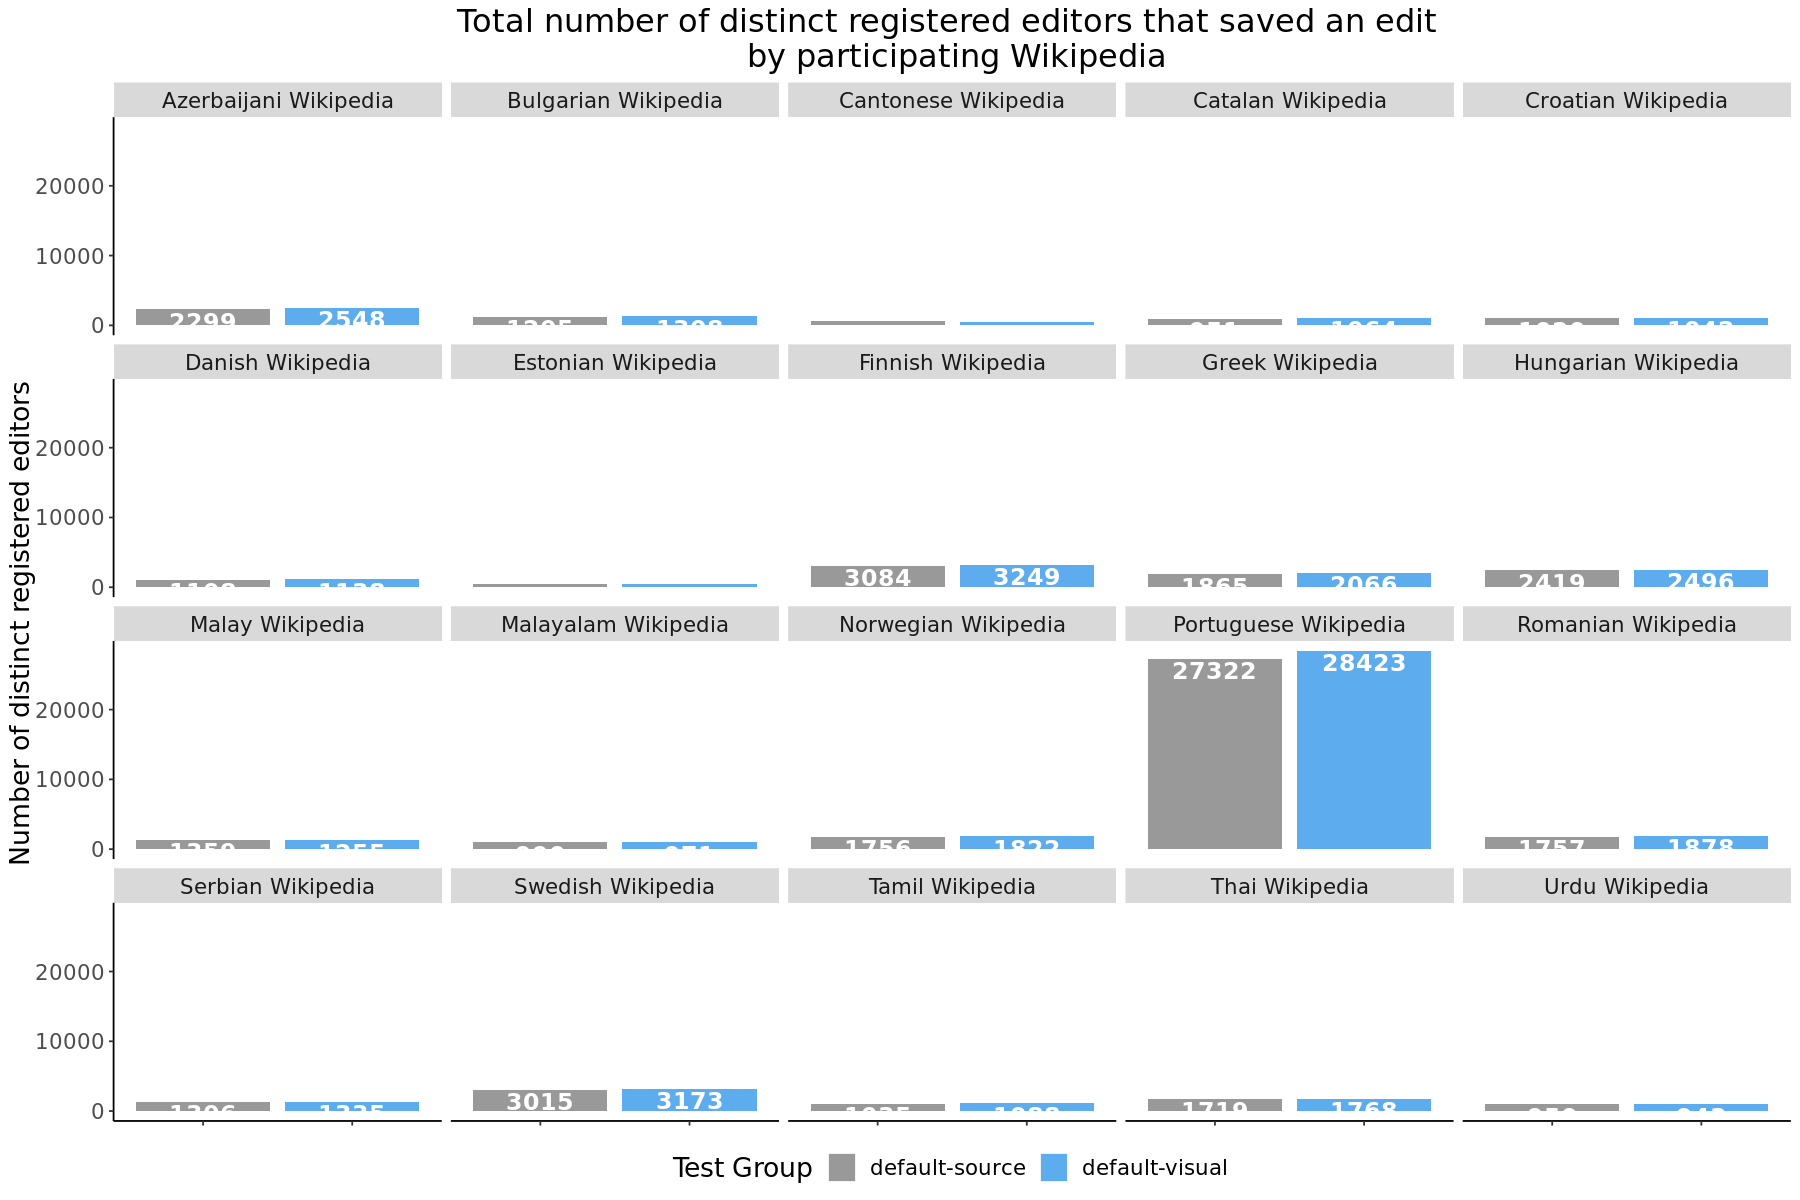

In [449]:
# number of distinct users
dodge <- position_dodge(width=0.9)

p <- num_edits_completed_bywiki  %>%
    ggplot(aes(x= bucket, y = n_users_saved , fill = bucket)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(n_users_saved), fontface=2), vjust=1.2, size = 5, color = "white") +
    facet_wrap(~ wiki) +
    scale_y_continuous() +
    labs (y = "Number of distinct registered editors ",
          title = "Total number of distinct registered editors that saved an edit \n by participating Wikipedia")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Test Group")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/num_users_completed_bywiki _plot.png", p, width = 16, height = 8, units = "in", dpi = 300)

# Load time

The  amount of time that elapses between when someone presses edit (`event.action = init`) and the editor is ready (`event.action = ready`).

**Method**: Found the average time difference between when someone presses edit and the editor is ready. I reviewed all data since the start of the AB test.


In [314]:
# load in editor data.
# Dataset limited to time period that included available anon data
load_time <-
  read.csv(
    file = 'Data/load_time_raw.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) 


## Overall

In [324]:
load_time_overall <- load_time %>%
    group_by(bucket)%>%
    summarize(avg_load_time = paste0(round(mean(ready_timing), 0), " ms"),
             median_load_time = paste0(median(ready_timing), " ms"))


In [323]:
# Create table of load times
load_time_overall_table <- load_time_overall  %>%
 gt() %>%
  tab_header(
    title = "Load time: Time lapsed between pressing the edit button and the editor loading",
    subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    bucket = "Test Group",
    avg_load_time = "Average load time",
    median_load_time = "Median load time"
  )%>%
    gtsave(
    "load_time_overall_table.html", inline_css = TRUE)

IRdisplay::display_html(data = load_time_overall_table , file = "load_time_overall_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 Load time: Time lapsed between pressing the edit button and the editor loading 
 
 
 across all participating Wikipedias 
 
 
 
 
 Test Group 
 Average load time 
 Median load time 
 
 
 
 
 default-source 
 1557 ms 
 380 ms 
 
 
 default-visual 
 4968 ms 
 1578 ms

Due to the presence of some extreme outliers, I’d recommend using median as a more accurate reflection of typical load time. 

Overall, across all participating Wikipedias and editors, there was a median increase of just a little over 1 second (1198 milliseconds [ms]) in median load time for editors shown VE as the default editor.


## Distribution of Load Times

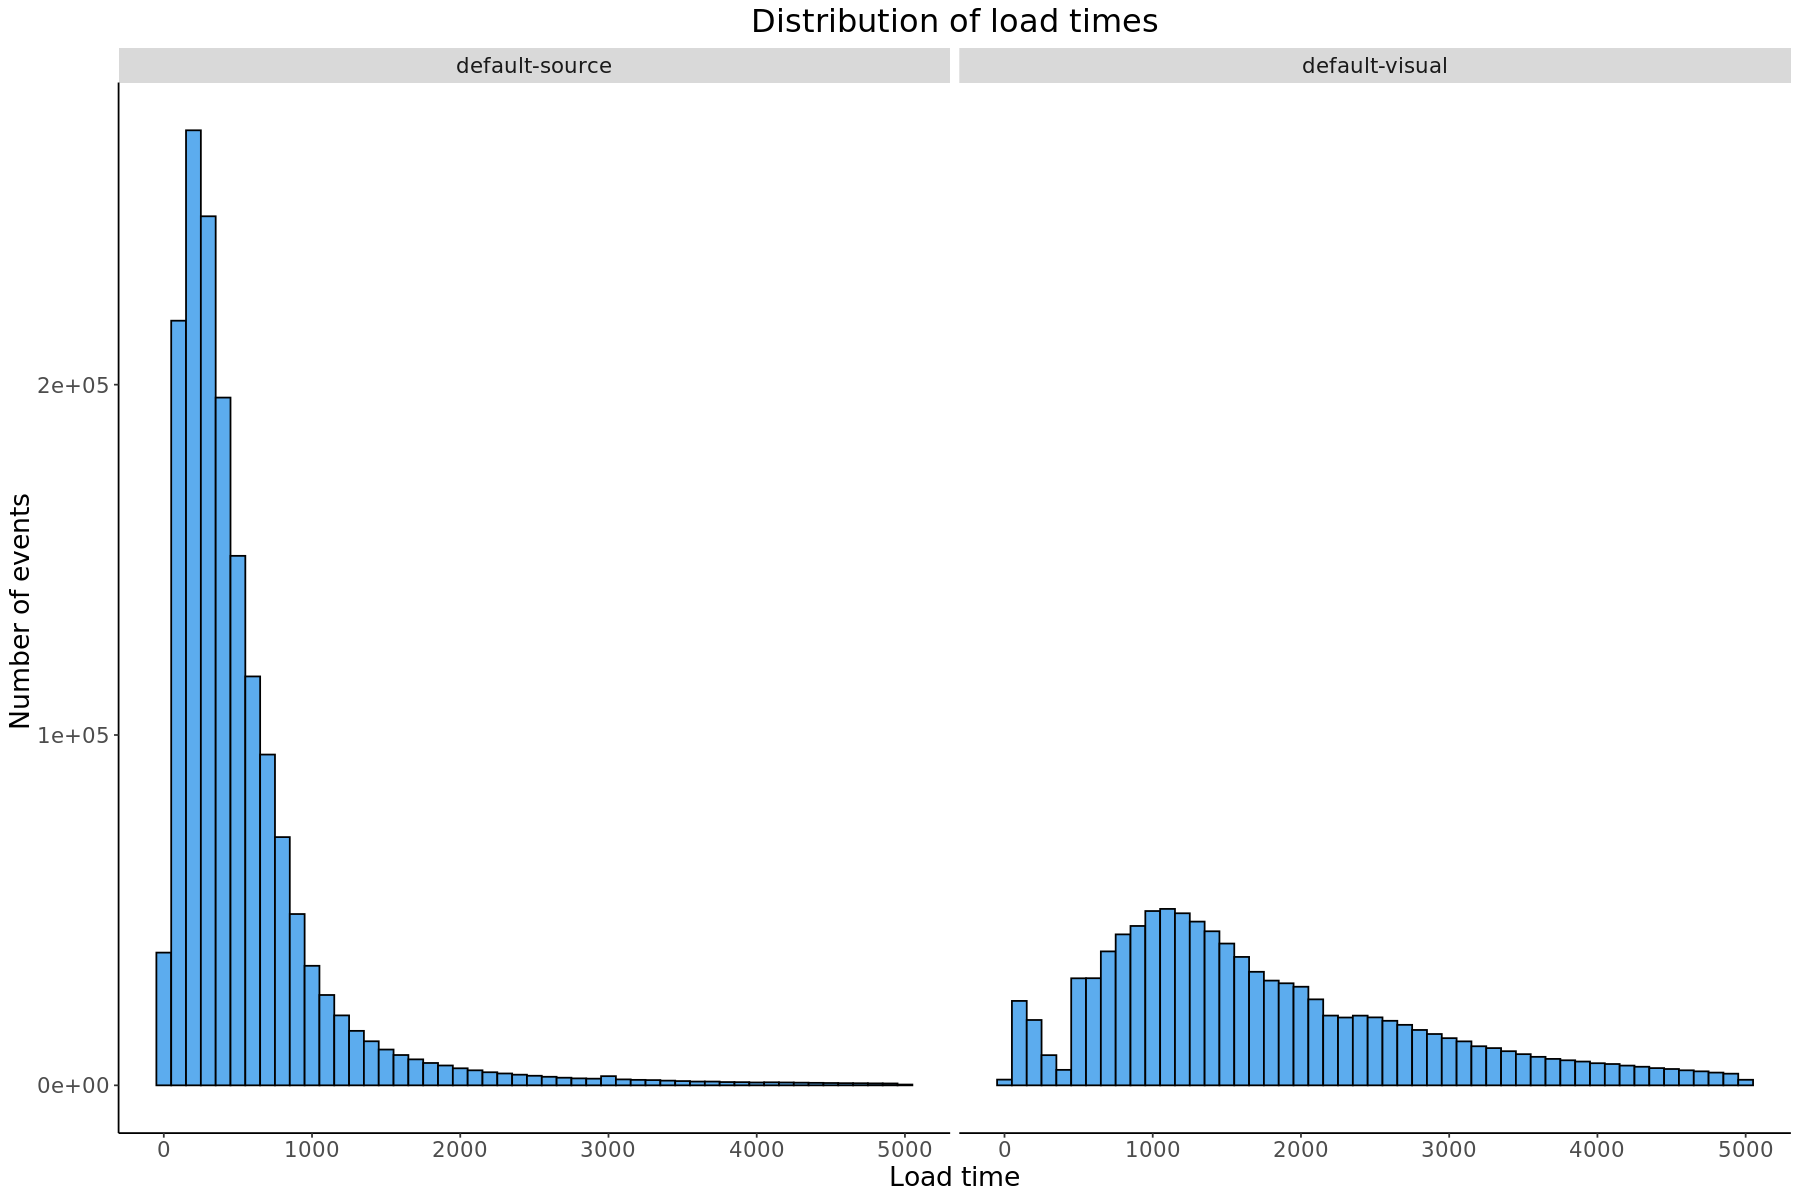

In [358]:
# plot distribution of load times to identifier outlier frequency

p <- load_time %>%
filter(ready_timing < 5000) %>% #remove outliers
ggplot(aes(x=ready_timing)) +
  facet_wrap(~bucket) +
  scale_y_continuous() +
 labs (y = "Number of events ",
       x = "Load time",
     title = "Distribution of load times"
      )  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Test Group")  +
  geom_histogram(binwidth = 100, color="black", fill="steelblue2") +
 theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.line = element_line(colour = "black")) 

p

## By Logged-in vs Logged-Out

In [458]:
load_time_byanon <- load_time %>%
    mutate(user_is_anon = ifelse(user_id == 0, 'Unregistered', 'Registered')) %>%
    group_by(user_is_anon , bucket)%>%
    summarize(avg_load_time = paste0(round(mean(ready_timing), 0), " ms"),
             median_load_time = paste0(median(ready_timing), " ms"))


In [459]:
# Create table of load times
load_time_byanon_table <- load_time_byanon  %>%
 gt(groupname_col = "user_is_anon") %>%
  tab_header(
    title = "Load time: Time lapsed between pressing the edit button and the editor loading",
    subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    bucket = "Test Group",
    avg_load_time = "Average load time",
    median_load_time = "Median load time"
  )%>%
    gtsave(
    "load_time_byanon_table.html", inline_css = TRUE)

IRdisplay::display_html(data = load_time_byanon_table , file = "load_time_byanon_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 Load time: Time lapsed between pressing the edit button and the editor loading 
 
 
 across all participating Wikipedias 
 
 
 
 
 Test Group 
 Average load time 
 Median load time 
 
 
 
 
 Registered 
 
 
 default-source 
 585 ms 
 345 ms 
 
 
 default-visual 
 3036 ms 
 1579 ms 
 
 
 Unregistered 
 
 
 default-source 
 1578 ms 
 380 ms 
 
 
 default-visual 
 5027 ms 
 1578 ms

We observed similar trends for both registered and unregistered users (just a little over a second increase in load time for editors shown VE as default).

## By Wikipedia

In [332]:
load_time_bywiki <- load_time %>%
    mutate(user_is_anon = ifelse(user_id == 0, 'Unregistered', 'Registered')) %>%
    group_by(wiki , bucket)%>%
    summarize(avg_load_time = round(mean(ready_timing),0),
             median_load_time = median(ready_timing))


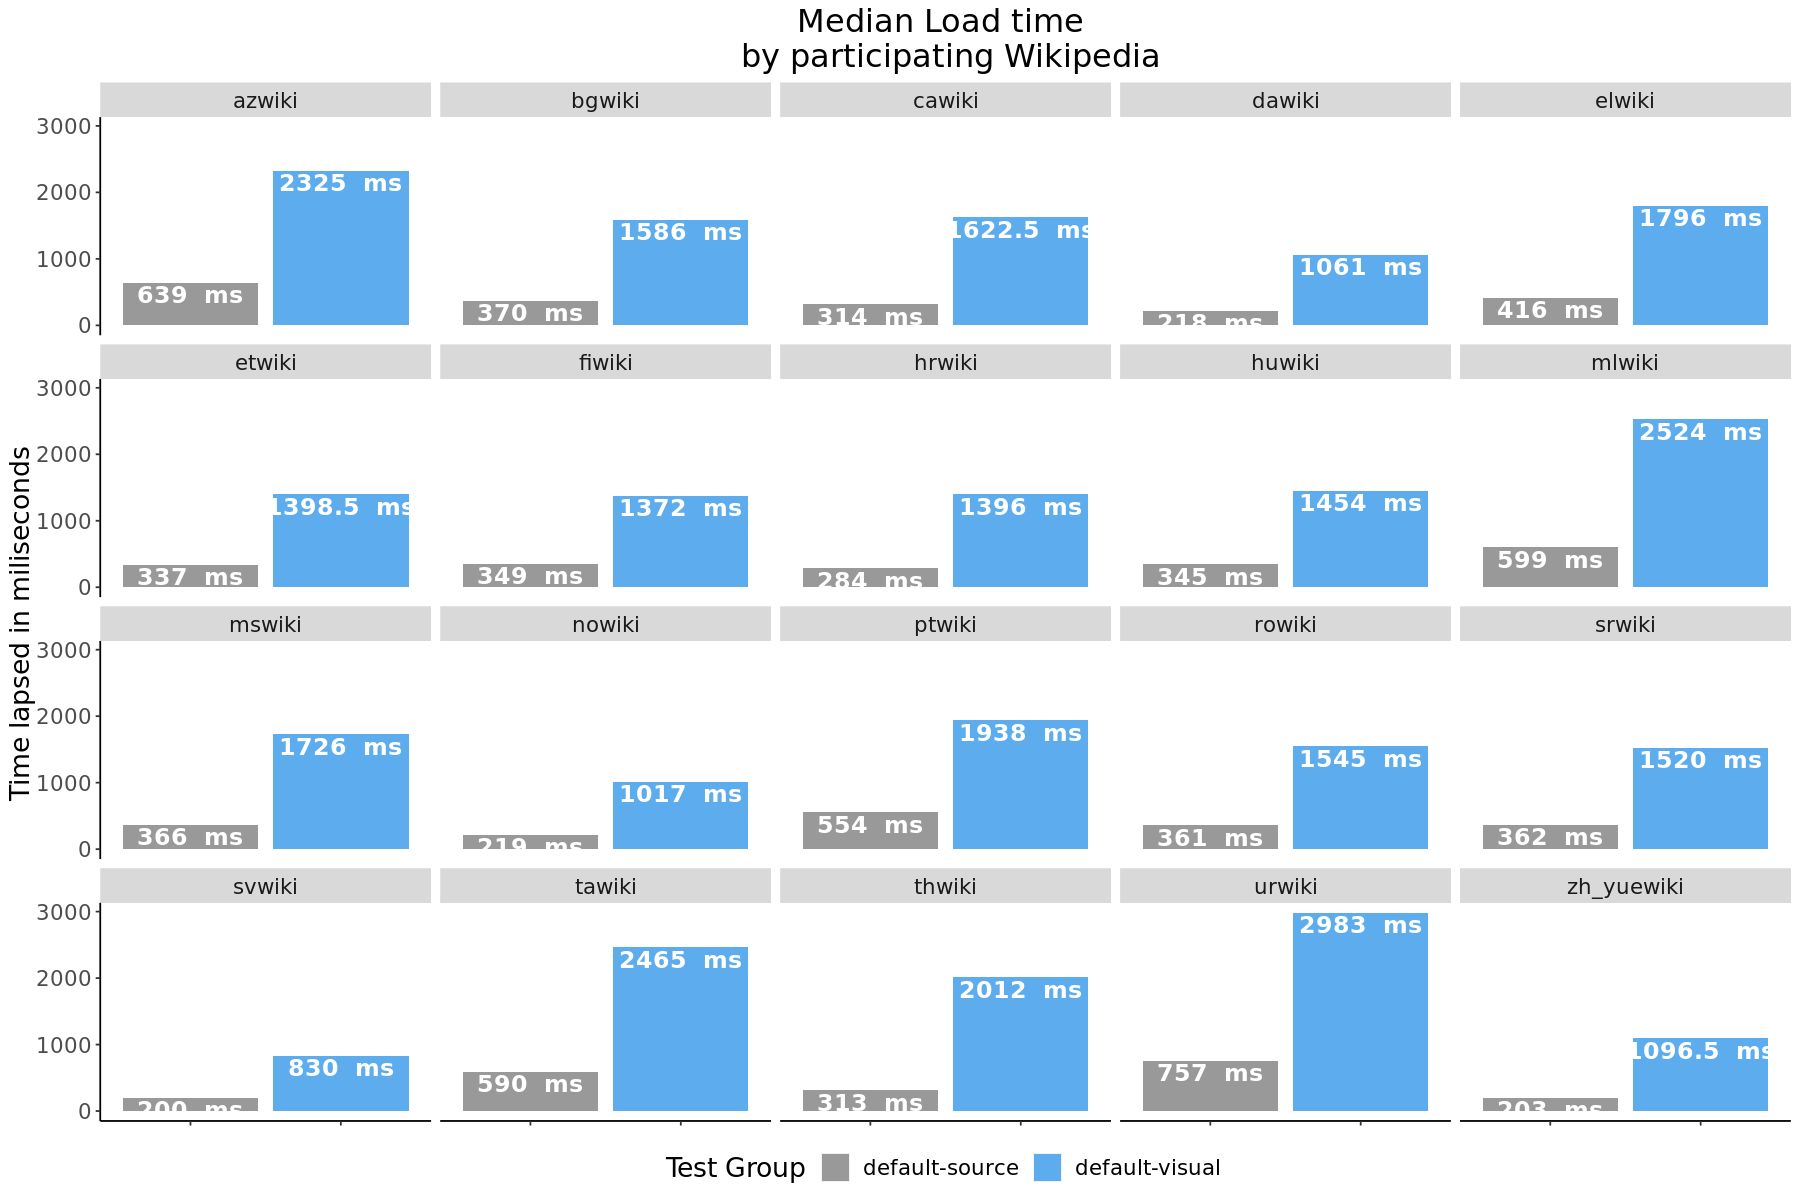

In [353]:
# plot avg load times per wiki
dodge <- position_dodge(width=0.9)

p <- load_time_bywiki  %>%
    ggplot(aes(x= bucket, y = median_load_time , fill = bucket)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(median_load_time, " ms"), fontface=2), vjust=1.2, size = 5, color = "white") +
    facet_wrap(~ wiki) +
    scale_y_continuous() +
    labs (y = "Time lapsed in miliseconds ",
          title = "Median Load time \n by participating Wikipedia")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Test Group")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/load_time_bywiki_plot.png", p, width = 16, height = 8, units = "in", dpi = 300)

In [ ]:
Trends are consistent on a per participating Wikipedia basis as well.